# EIT Continuous Model Complex-Valued Tests

This work aims to set first tests with EIT implementantion using FENICSx library, aiming to solve the complex valued case, explaining some of the fundamentals in the library implementation. In this context, we will be using the Continuous Model, testing initially with trivial simulated functions and simple meshes, adding more information and complexity as advancing.

More information and explanations about some steps can be seen in the FENICSx tutorial: https://jsdokken.com/dolfinx-tutorial/chapter1/complex_mode.html.


## EIT Continuous Model

Given a domain $\Omega \in \mathbb R^2$, an admitivity $\gamma: \Omega \to \mathbb C$, a potential distribution $u : \Omega \to \mathbb  C$ and a current $g : \partial \Omega \to \mathbb R$ in the border $\partial \Omega$ of $\Omega$, the EIT Continuous Model stablishes the following PDE:

$$
\nabla \cdot ( \gamma \nabla u) = 0, \text{ in } \Omega\\
\gamma \frac{\partial u}{\partial \eta} = g, \text{ in } \partial \Omega
$$

First equation also may be written as $div(\gamma \nabla u) = g$.

This PDE with stablished conditions may also be transformed in a weak variational formulation. Basically, we want to find $u$ such that for any given $v \in H^1_{\Diamond}$, it solves:

$$
\int_{\Omega} \gamma \nabla u \cdot \nabla v dx = \int_{\partial \Omega} g v dS
$$,

where $H^1_{\Diamond} = \{f \in H^1 : \int_{\partial \Omega} f = 0\}$.

# Implementation - Direct Problem



## Importing

Run the following blocks to install and import all the libraries required.

In [30]:
try:
    import gmsh
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [31]:

try:
    import dolfinx
except ImportError:
  !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
  import dolfinx

In [32]:
try:
    import pyvista
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista

pyvista.set_jupyter_backend("static")

In [33]:
import sys
import dolfinx
from mpi4py import MPI #import parallel communicator
import numpy as np
import ufl
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
from dolfinx.io import gmshio
import time

print("Python version: ", sys.version)
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")


#Check type of number set in PETSc lib, returns error if not complex
from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
DOLFINx version: 0.8.0.0 based on GIT commit: 230e027269c0b872c6649f053e734ed7f49b6962 of https://github.com/FEniCS/dolfinx/
<class 'numpy.complex128'>


### Auxiliar Functions

In [34]:
def get_boundary_data(domain, u, V):
  """
  Returns an array of function values on boundary, ordered by the angle theta
  """
  domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
  boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
  boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index

  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
  y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]

  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  sorted_theta_index = np.argsort(theta)
  return u.x.array[boundary_dofs_index_array][sorted_theta_index]

def get_boundary_index(V):
  """
  Returns an array of boundary index data, ordered by the angle theta
  """
  domain = V.mesh
  domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
  boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
  boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
  y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]

  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  sorted_theta_index = np.argsort(theta)
  return boundary_dofs_index_array[sorted_theta_index]

def get_boundary_theta_array(V):
  """
  Return of an array of the angle theta of each (x,y) boundary vertex,
  with respect to default parametrization
  """
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  boundary_index = get_boundary_index(V)
  x_bdr = dofs_coordinates[boundary_index][:,0]
  y_bdr = dofs_coordinates[boundary_index][:,1]
  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  # sorted_theta_index = np.argsort(theta)
  return theta


def plot_vertex_function(u_array_data, V):
  """
  Plot a vertex function ('tent' space) given

  u_array_data: np.array
    Array of function coefficients
  V: FunctionSpace
    u Function Space
  """
  # p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
  pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)

  grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

  grid.point_data["u"] = u_array_data
  #Plot real

  grid.set_active_scalars("u")
  p = pyvista.Plotter(notebook=True,window_size=(300,300))
  # p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
  p.add_mesh(grid, show_edges=True)
  p.view_xy()
  p.set_background("white")
  if not pyvista.OFF_SCREEN:
      p.show()

def solveDirect(gamma,g,V):
  """
    Solve direct problem for a single admitivity and current
  """
#Left hand side
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * ufl.dx #\int \nabla u * \overline \nabla v dx

  #Right hand side
  L = ufl.inner(g,v) * ufl.ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':20})
  usol = problem.solve()
  return usol

def directionDerivate(gamma, us, eta):
  #Create Trial and test functions
  w = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  #creates object representing the gradient of w, us and v functions
  gradw = ufl.grad(w)
  gradv = ufl.grad(v)
  gradus = ufl.grad(us)

  dx = ufl.dx #object for domain infinitesimal entities (triangles)
  ds = ufl.ds # object for boundary infinitesimal entities (line segments)

  #Left gand side
  a = (gamma * ufl.inner(gradw, gradv)) * dx

  #Right hand side
  L = - (eta * ufl.inner(gradus,gradv)) * dx

  #Solving problem
  problem = dolfinx.fem.petsc.LinearProblem(a,L,jit_options={'timeout':20})
  ws = problem.solve()
  return ws

## Setting mesh

More details on gmsh library are in their reference manual: https://gmsh.info/doc/texinfo/gmsh.html.

It is recommended to check the Python files provided on the reference tutorial, seen that the examples provided are in '.geo' language. Most relevant tutorials for this scenario are t1 and t10, respectively the gmsh basics and the mesh refinement tutorials.

In [48]:
mesh_refining = 0.2
bdr_refining = 0.5 # scalling factor for border refining


# if running again, you must remove the comment in the following
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 20
points = [gmsh.model.occ.addPoint(np.cos(i*np.pi/(n/2)),np.sin(i*np.pi/(n/2)),0) for i in range(n)]

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2 * mesh_refining)


# control mesh refinement
# see gmsh tutorial for further instructions
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "PointsList", points)

#sets a threshold field
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)

# Lines below sets how we want mesh refiniment
# the used parameters perform a relation like the following
#
#
# SizeMax -                     /------------------
#                              /
#                             /
#                            /
# SizeMin -o----------------/
#          |                |    |
#        Point         DistMin  DistMax
gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.03 * bdr_refining)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.25 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.1 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.3 * bdr_refining)

#sets a general size, based on the calculated sizes and distances
gmsh.model.mesh.field.add("Min", 3)
gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])

gmsh.model.mesh.field.setAsBackgroundMesh(3)

# This value is then constrained in the interval [`Mesh.MeshSizeMin',
# `Mesh.MeshSizeMax'] and multiplied by `Mesh.MeshSizeFactor'. In addition,
# boundary mesh sizes are interpolated inside surfaces and/or volumes depending
# on the value of `Mesh.MeshSizeExtendFromBoundary' (which is set by default).
#
# When the element size is fully specified by a mesh size field (as it is in
# this case), it is thus often desirable to set the options below
# This will prevent over-refinement due to small mesh sizes on the boundary.

gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)

gmsh.model.mesh.generate(gdim)

## Plotting domain

static


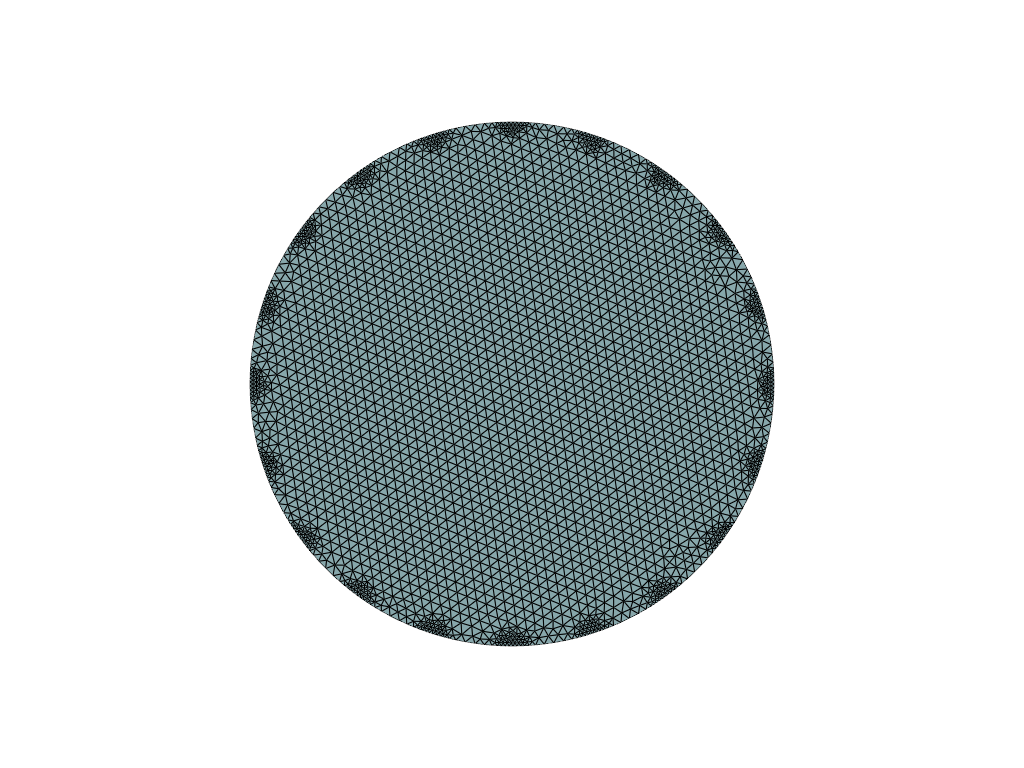

In [49]:
from dolfinx.io import gmshio



# plotter object settings
# option "static" for static plots. Interactive options were not working properly in colab
pyvista.set_jupyter_backend("static")
print(pyvista.global_theme.jupyter_backend)

#start graphic server
pyvista.start_xvfb()

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

#convert dolfin mesh to vtk (plotting lib) manageable object
topology, cell_types, x = dolfinx.plot.vtk_mesh(domain)

#set value (plotting zero function in domain)
num_cells_local = domain.topology.index_map(domain.topology.dim).size_local #get vertex array size
marker = np.zeros(num_cells_local, dtype=np.int32) #zero-full array, represents value in each vertex

# Ploting mesh
p = pyvista.Plotter(notebook=True)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

## Defining problem

Here, we perform the first tests running an example with a current $g$ defined by:
$$
g = 4y^2 - 4x^2.
$$

The following code define this current in the whole domain $\Omega$, including the boundary.

In [ ]:
x = ufl.SpatialCoordinate(domain)
g = 4*x[1]**2 - 4*x[0]**2

In [ ]:
V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))

#Create Trial and test functions
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

Next, we set the function for admitivity $\gamma : \Omega \to \mathbb C$. In this test, we set the constant function defined by:

$$
\gamma(x) = 1 + i, \forall x \in \Omega.
$$

In [ ]:
#gamma
gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1)) #defining constant 1+1j function over mesh
# gamma = x[0]+x[1]

In the next code block, we set left and right hand sides of variational equation. This will be handed by the `ufl`, which handles the variational expressions symbolicaly by the created objects. Fenicsx will handle the work of applying the created expressions in the set domain.

First, we create objects `gradu` and `gradv`, which do the role of $\nabla u$ and $\nabla v$ respectively.

Secondly, we set names for ufl objects `dx` and `ds`, representing respectively the area and surface length infinitesimals of integral. With them, we can represent an integral like

$$
 \int_\Omega f(x) dx
$$
in the form `f * dx`.

Finally, we write the expressions for the left-handside `a(u,V)` and right handside `F(v)`.

In [ ]:
#creates object representing the gradient of u and v functions
gradu = ufl.grad(u)
gradv = ufl.grad(v)

dx = ufl.dx #object for domain infinitesimal entities (triangles)
ds = ufl.ds # object for boundary infinitesimal entities (line segments)

#Left gand side
a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ds

#Obs: inner product is set to consider the conjugate in second term

In [ ]:
print(a)

{ c_0 * (conj(((grad(v_0)) : (grad(v_1))))) } * dx(<Mesh #0>[everywhere], {})


Now, we may solve the problem using the following commands. First line creates a linear problem, given the `a` and `L` sides create above, and second line solves it saving on variable `us`.

In [ ]:
#Solving problem
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

### Direct Solver Function

In [ ]:
def solveDirect(gamma,g,V):
#Left gand side
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

  #Right hand side
  L = ufl.inner(g,v) * ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':60})
  usol = problem.solve()
  return usol

## Plotting solutions

In [ ]:
pyvista.global_theme.font.color = "black"
pyvista.global_theme.color = "white"
pyvista.start_xvfb()

# p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = us.x.array.real
grid.point_data["u_imag"] = us.x.array.imag

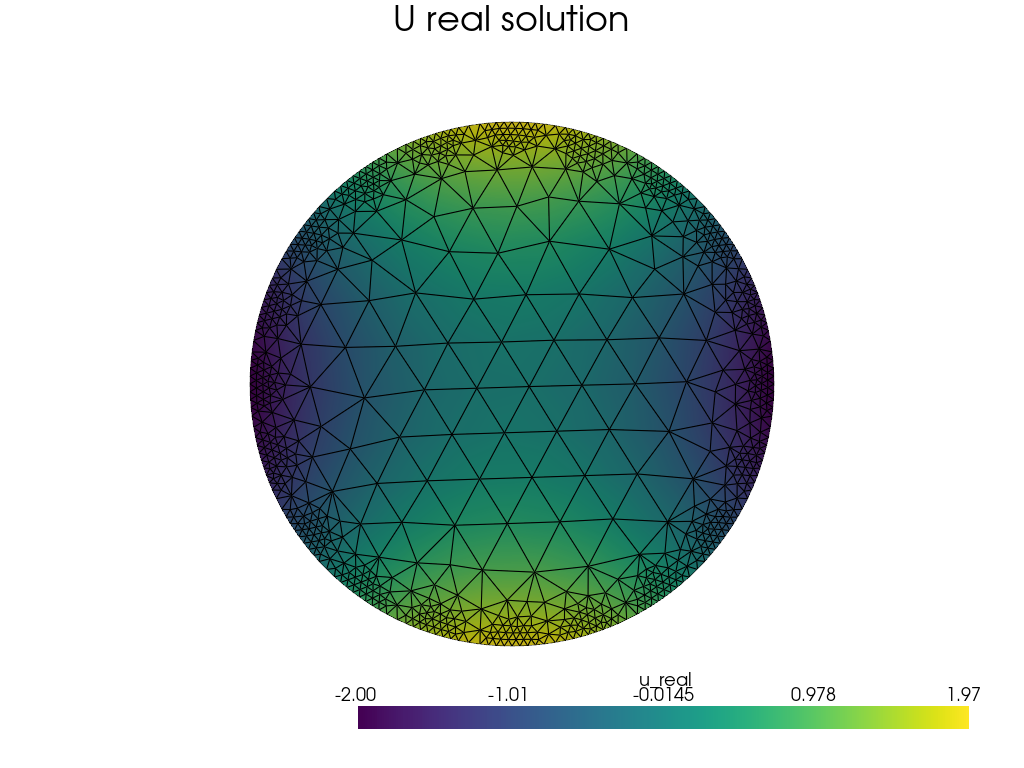

In [ ]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

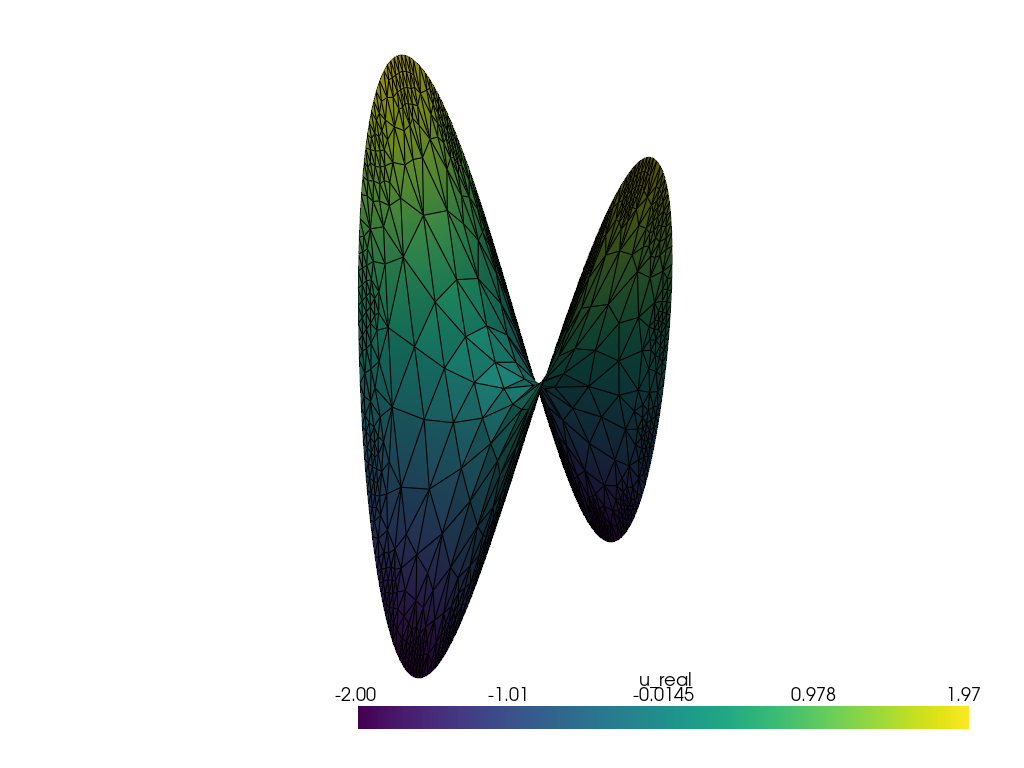

In [ ]:
warped = grid.warp_by_scalar()
plotter2 = pyvista.Plotter(notebook=True)
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

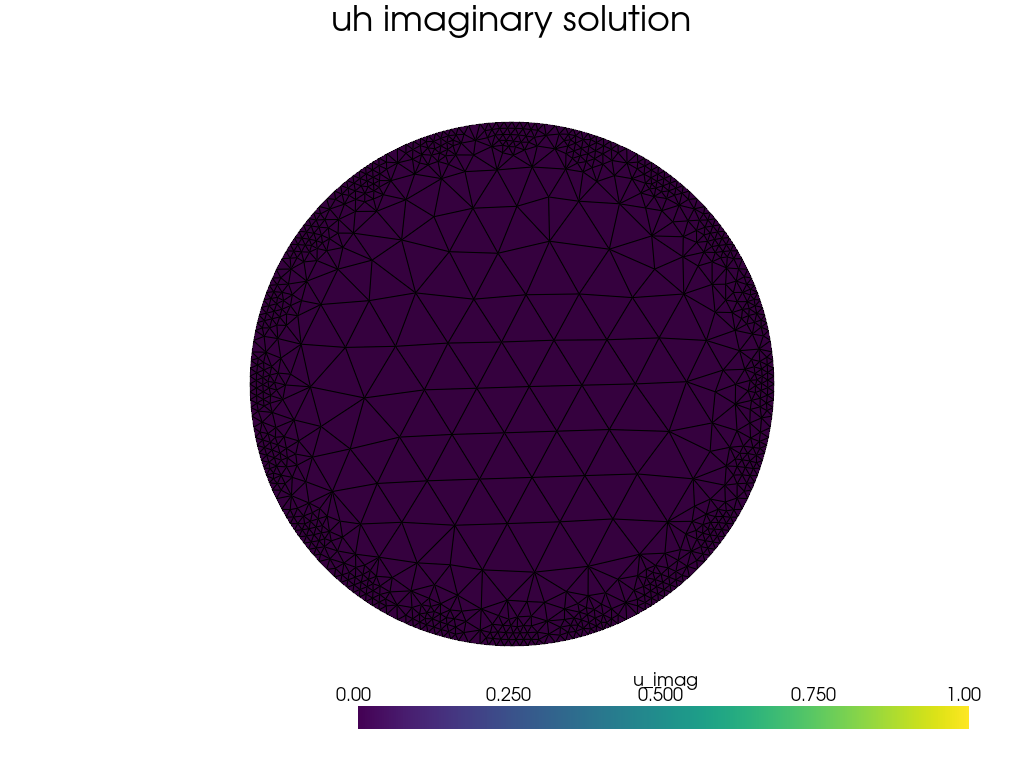

In [ ]:
#Plot imag
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter(notebook=True)
p_imag.add_text("uh imaginary solution", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
p_imag.set_background("white")
if not pyvista.OFF_SCREEN:
    p_imag.show()

## Plotting on Boundary



### First Method - Parametrized curve

Based on example https://jsdokken.com/dolfinx-tutorial/chapter1/membrane_code.html#making-curve-plots-throughout-the-domain.

We parametrize a curve for the boundary, in this case using $\phi(t) = (cos(t), sin(t))$, creating a discretized array for the domain. Next, we evaluate the $u$ value for each $(x(t),y(t))$, based on the solution found.

Because of numerical error, we have to stablish a tolerance, parametrize a circle with radius slightly smaller than 1. This avoid to get points out of domain.

In [ ]:
from dolfinx import geometry
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

In [ ]:
# Parametrizing x and y through the border
# Here, we have to stablish a tolerance, get a circle with radius slightly smaller than 1
# This avoid to get points out of domain
x_bdr = 0.999*np.cos(np.linspace(0,2*np.pi,200))
y_bdr = 0.999*np.sin(np.linspace(0,2*np.pi,200))

# Creates a matrix stacking each point as a column
# Although we are working in a 2d model, fenicsx still understand as a 3d
# So, we still must provide z coordinates, in this case setting all 0
points = np.vstack([x_bdr,y_bdr,np.zeros(200)])

In [ ]:
#creates list for the cells indexes
cells = []

# Find cells whose bounding-box collide with the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)

# Creates a list with lists of cells wich collide to each point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)

# Selects for each point, only the first cell in the list
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        cells.append(colliding_cells.links(i)[0])

In [ ]:
len(cells)

200

In [ ]:
us_bdr = us.eval(points.T,cells)

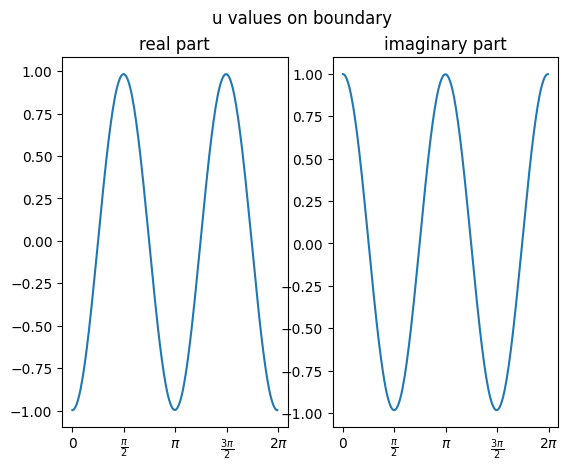

In [ ]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2)

axs[0].plot(us_bdr.real)
axs[0].set_title("real part")
axs[0].set_xticks(np.arange(0,201,50),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(us_bdr.imag)
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.arange(0,201,50),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary")
plt.show()

With the parameterization $\varphi(t) = (cos(t),sin(t))$, the exact solution have the form:
$$
u(\varphi(t)) = -[cos^2(t) - sin^2(t)] + i [cos^2(t) - sin^2(t)].
$$

So, below we perform a comparison between the boundary values for the calculated solution and the exact solution.

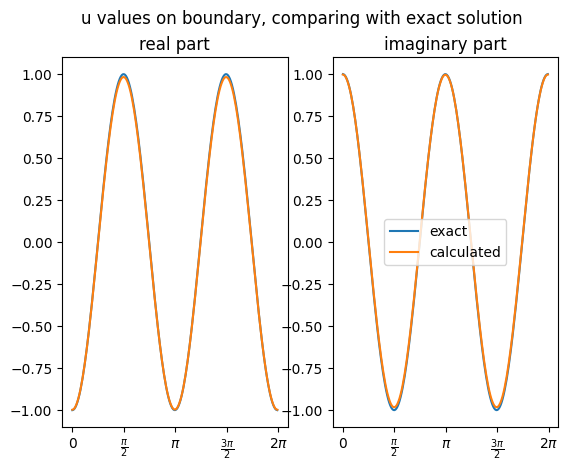

In [ ]:
f = lambda t: np.cos(t)**2 - np.sin(t)**2
t = np.linspace(0,2*np.pi,200)
fig,axs = plt.subplots(1,2)

axs[0].plot(-f(t),label="exact")
axs[0].plot(us_bdr.real,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.arange(0,201,50),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(f(t),label="exact")
axs[1].plot(us_bdr.imag,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.arange(0,201,50),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary, comparing with exact solution")
plt.legend()
plt.show()

### Second Method - Locating boundary vertices

Based on the Poisson problem complex tutorial and the following answer: https://fenicsproject.discourse.group/t/fenicsx-use-an-array-of-data-for-boundary-conditions/9194/2

This method principle is to get the boundary vertex index, to get the exact $u$ coefficients through this index. There is one problem that the boundary index are not ordered by the "angle", which make the parametric plot more difficult.

In this case, we first get every boundary $(x,y)$ coordinate and determine the corresponding $t$ parameter in $\phi(t) = (cos(t), sin(t))$ parametrization. Next, we found the index for the sorted $t$ values array. This allows us to order the array for the $u|_{\partial \Omega}$ values, using this index for the sorted $t$.

In [ ]:
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index

In [ ]:
u_bdr_real_array = us.x.array.real[boundary_dofs_index_array]
u_bdr_imag_array = us.x.array.imag[boundary_dofs_index_array]

In [ ]:
#gets x and y coordinates for the boundary
dofs_coordinates = V.tabulate_dof_coordinates()
x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]


In [ ]:
#gets the t in [0,2pi] from the corresponding (x,y) coordinates
#next, gets the index of the sorted t array
theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
sorted_theta_index = np.argsort(theta)

In [ ]:
#get solution coefficients based on the boundary index and sorting by t
u_bdr_real_array = us.x.array.real[boundary_dofs_index_array][sorted_theta_index]
u_bdr_imag_array = us.x.array.imag[boundary_dofs_index_array][sorted_theta_index]

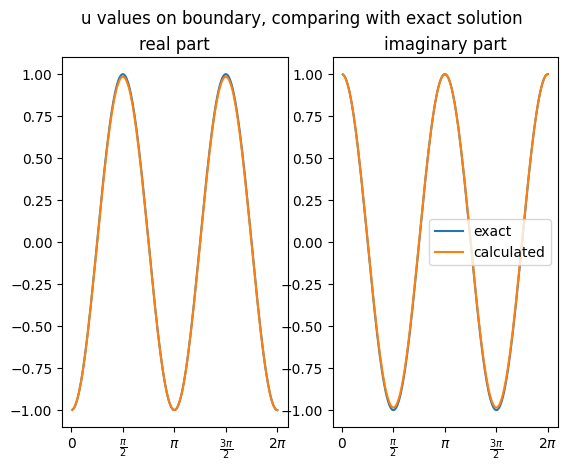

In [ ]:
f = lambda t: np.cos(t)**2 - np.sin(t)**2
t = theta[sorted_theta_index]
fig,axs = plt.subplots(1,2)

axs[0].plot(t,-f(t),label="exact")
axs[0].plot(t,u_bdr_real_array,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(t,f(t),label="exact")
axs[1].plot(t,u_bdr_imag_array,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary, comparing with exact solution")
plt.legend()
plt.show()

In [ ]:
u_bdr_real_array.shape

(192,)

## Error Analysis

Here, we perform the error analysis. The expected solution, given $g(x) = 4y^2 - 4x^2$ and $\gamma(x,y) = 1 + i$ is the function $u$ given by
$$
u(x,y) = (-1+i)x^2 - (-1+i)y^2.
$$
tw
Then, in the following code we:
1. Create the object `uex` for the exact solution, interpolating the function with the given expression.
2. Calculate the squared $L^2$ norm error given by $\|u_{ex} - u_s\|^2 = \int (u_{ex} - u_s)\cdot \overline{(u_{ex} - u_s)}dx$, saving in `l2error` variable.
3. Getting the root of squared error, saving in `square_error`.

For creating `uex`, we create an secondary function space named `V2`, corresponding to the $V$ space with quadratic interpolation, i.e., 2-degree of freedom. This gives an more accurate representation of the "exact" function.

In [ ]:
# Defining exact solution
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))
uex = dolfinx.fem.Function(V2, dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

l2error = dolfinx.fem.form(ufl.inner(us-uex,us-uex) * ufl.dx)
squareerror = dolfinx.fem.assemble_scalar(l2error)

l2normerror = np.sqrt(squareerror)
max_error = np.max(np.abs(squareerror))

print("L2 norm error: ", l2normerror)
print("Max error: ",max_error)

L2 norm error:  (0.021236688289532443+0j)
Max error:  0.00045099692950676437


In [ ]:
pyvista.global_theme.font.color = "black"
pyvista.global_theme.color = "white"
pyvista.start_xvfb()

# p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V2)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = uex.x.array.real
grid.point_data["u_imag"] = uex.x.array.imag

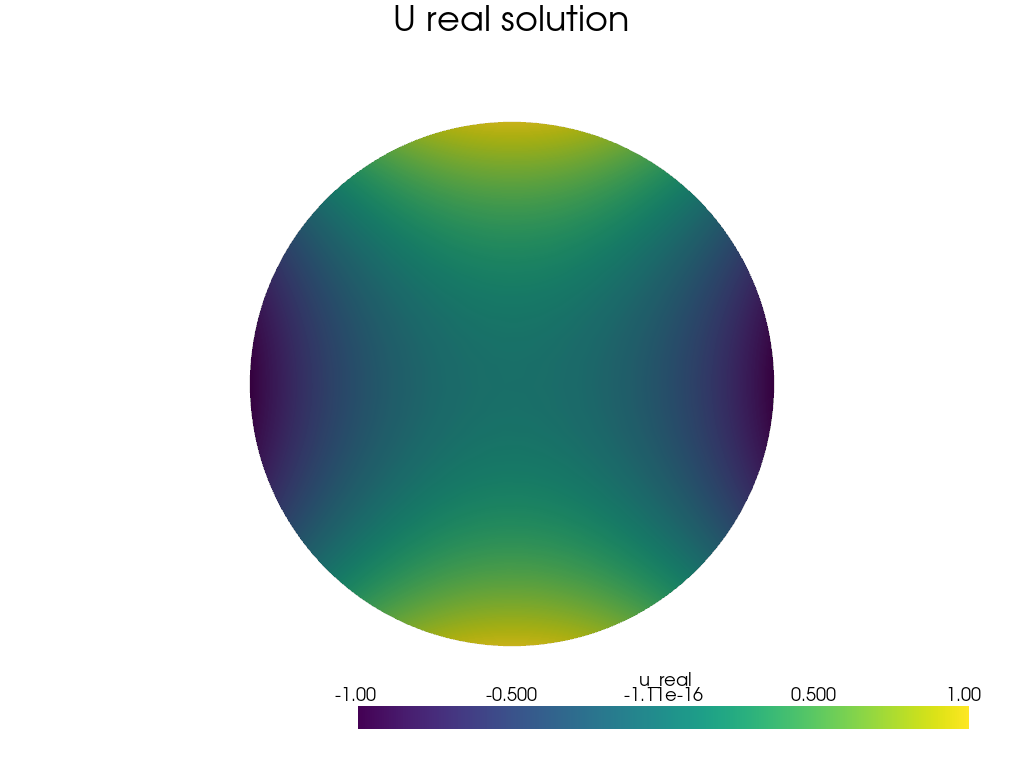

In [ ]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=False)
p_real.view_xy()
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

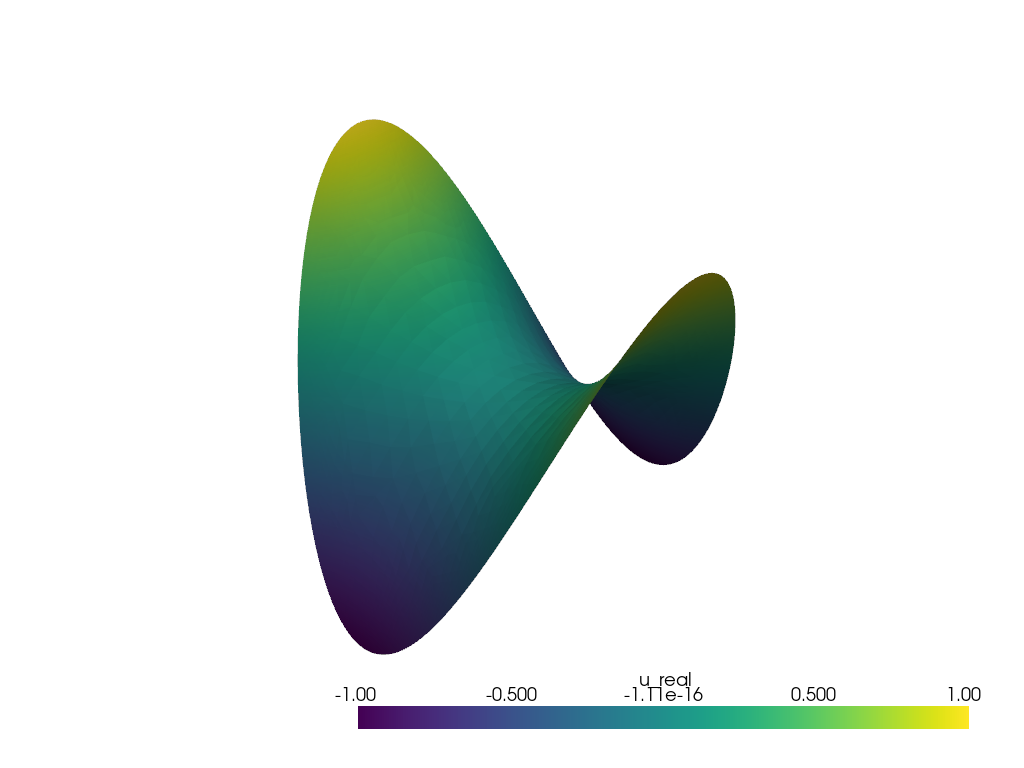

In [ ]:
warped = grid.warp_by_scalar()
plotter2 = pyvista.Plotter(notebook=True)
plotter2.add_mesh(warped, show_edges=False, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

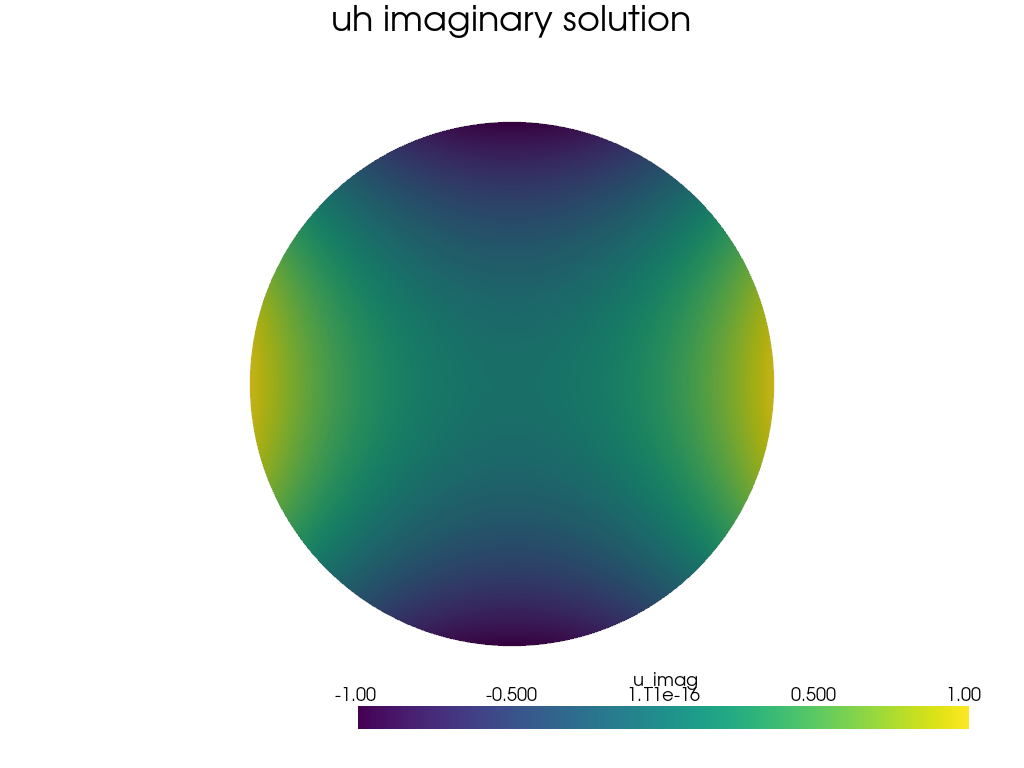

In [ ]:
#Plot imag
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter(notebook=True)
p_imag.add_text("uh imaginary solution", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=False)
p_imag.view_xy()
p_imag.set_background("white")
if not pyvista.OFF_SCREEN:
    p_imag.show()

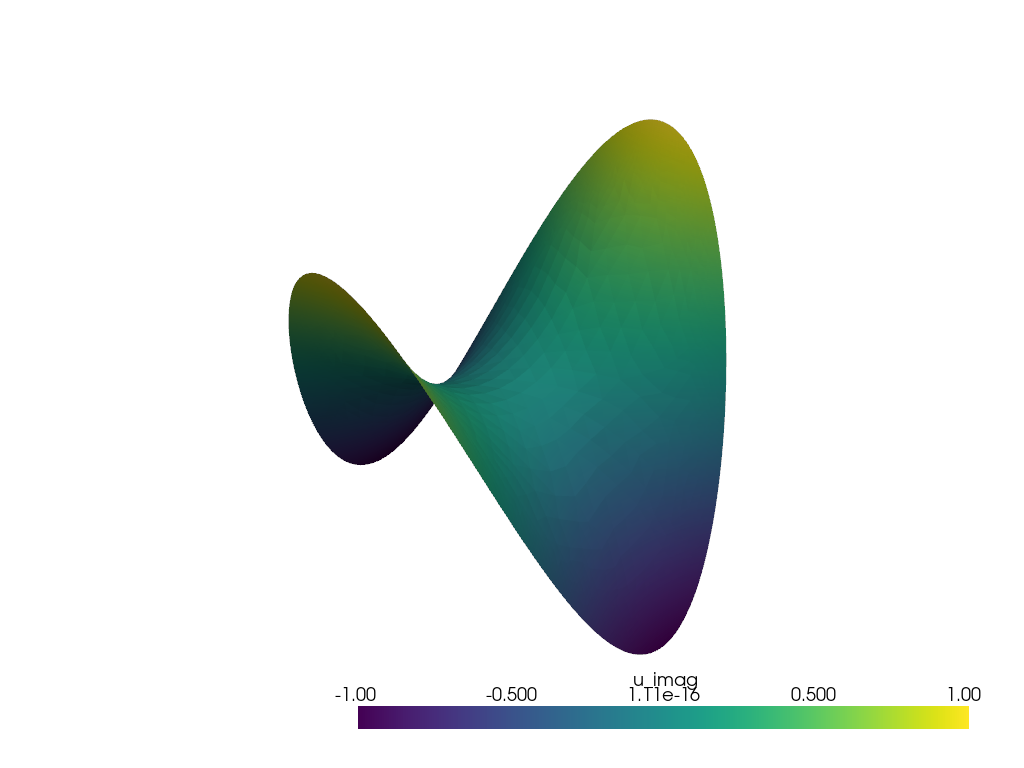

In [ ]:
warped = grid.warp_by_scalar()
plotter2 = pyvista.Plotter(notebook=True)
plotter2.add_mesh(warped, show_edges=False, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

## Calculus of Derivative

Here, given a current $g_i:\partial \Omega \to \mathbb R$, we are interested in the directional derivatives of the operator $F_i$, which associate the given $\gamma$ to the respective potential in border $f_i$, with the relation
$$
F_i(\gamma) = \Lambda_\gamma(g_i) = f_i.
$$.

Given current $g_i$ and admitivity $\gamma$, we obtain the potential $u_\gamma^{(i)} = F(\gamma)$ by the direct operator calculus. For a given direction $\eta$, it is kwown that the directional derivative $F'_i(\gamma)\eta$ is the restriction $\omega^{(i)}\big |_{\partial \Omega}$ of the solution $\omega^{(i)}$ for
$$
\int_\Omega \gamma \nabla \omega^{(i)} \nabla v dx = - \int_{\partial \Omega} \eta \nabla u^{(i)}_\gamma \nabla v dx, \forall v \in H_\diamond^1(\Omega).
$$


### Defining eta

In [ ]:
#eta
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
eta.x.array[900:950] = 1+1j #define the triangle with index 900 as 1, rest remain as 0

In [ ]:
def locate_circle(x):
  return (x[0]-0.2)**2 + (x[1]-0.2)**2<=0.3**2


In [ ]:
#Plotting eta
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.cell_data["$\eta$ Real"] = eta.x.array.real
grid.cell_data["$\eta$ Imaginary"] = eta.x.array.imag



In [ ]:
grid.set_active_scalars("$\eta$ Real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")


ERROR:root:bad X server connection. DISPLAY=:99. Aborting.


In the next code block, we set left and right hand sides of variational equation relative to the directional derivative

In [ ]:
#Create Trial and test functions
w = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

#creates object representing the gradient of w, us and v functions
gradw = ufl.grad(w)
gradv = ufl.grad(v)
gradus = ufl.grad(us)

dx = ufl.dx #object for domain infinitesimal entities (triangles)
ds = ufl.ds # object for boundary infinitesimal entities (line segments)

#Left gand side
a = (gamma * ufl.inner(gradw, gradv)) * dx

#Right hand side
L = - (eta * ufl.inner(gradus,gradv)) * dx

#Solving problem
problem = dolfinx.fem.petsc.LinearProblem(a,L,jit_options={'timeout':20})
ws = problem.solve()

NameError: name 'ufl' is not defined

### Testing derivative

Here, we compare the calculated derivative $\omega^{(i)}$ with the numerical derivative, given by:
$$
\frac{F_i(\gamma + t\eta) - F_i(\gamma -t \eta)}{2t},
$$
for some $t\in \mathbb R_+^*$ close to $0$.

The proposed test is, from the previusly set $\gamma$ and $\eta$, create a sequence $t_k$ such that $t_k \to 0$, analysing the sequence
$$
e_k = \left \| \frac{F_i(\gamma + t_k\eta) - F_i(\gamma -t_k \eta)}{2t} - \omega^{(i)}\right \|
$$
calculating $F_i(\gamma + t_k\eta)$ and $F_i(\gamma - t_k\eta)$ in each step through the process described before.


In [ ]:
def solveDirect(gamma,g,V):
#Left gand side
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

  #Right hand side
  L = ufl.inner(g,v) * ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':20})
  usol = problem.solve()
  return usol

In [ ]:
N = 50
err_array = np.zeros(N)
for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)
  num_diff_Fi = (fwd_F - bwd_F)/(2*t)

  error = num_diff_Fi - ws

  l2error = dolfinx.fem.form(ufl.inner(error,error) * ufl.ds)
  norm_ws = dolfinx.fem.form(ufl.inner(ws,ws) * ufl.ds)
  squareerror = dolfinx.fem.assemble_scalar(l2error)
  squarenorm = dolfinx.fem.assemble_scalar(norm_ws)
  l2normerror = np.sqrt(squareerror)
  squarenorm = np.sqrt(squarenorm)
  err_array[i] = l2normerror.real / squarenorm.real

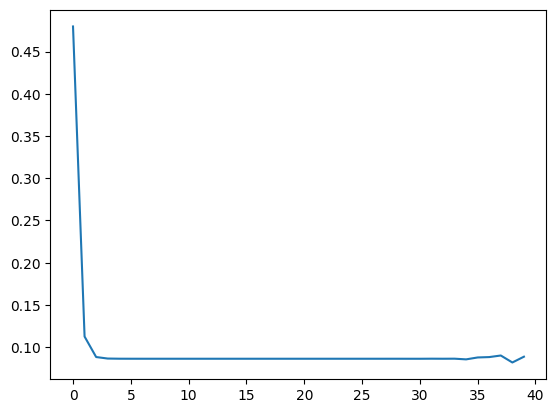

In [ ]:
plt.plot(err_array[:40])

In [ ]:
#Plotting eta
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["ws Real"] = ws.x.array.real
grid.point_data["ws Imaginary"] = ws.x.array.imag



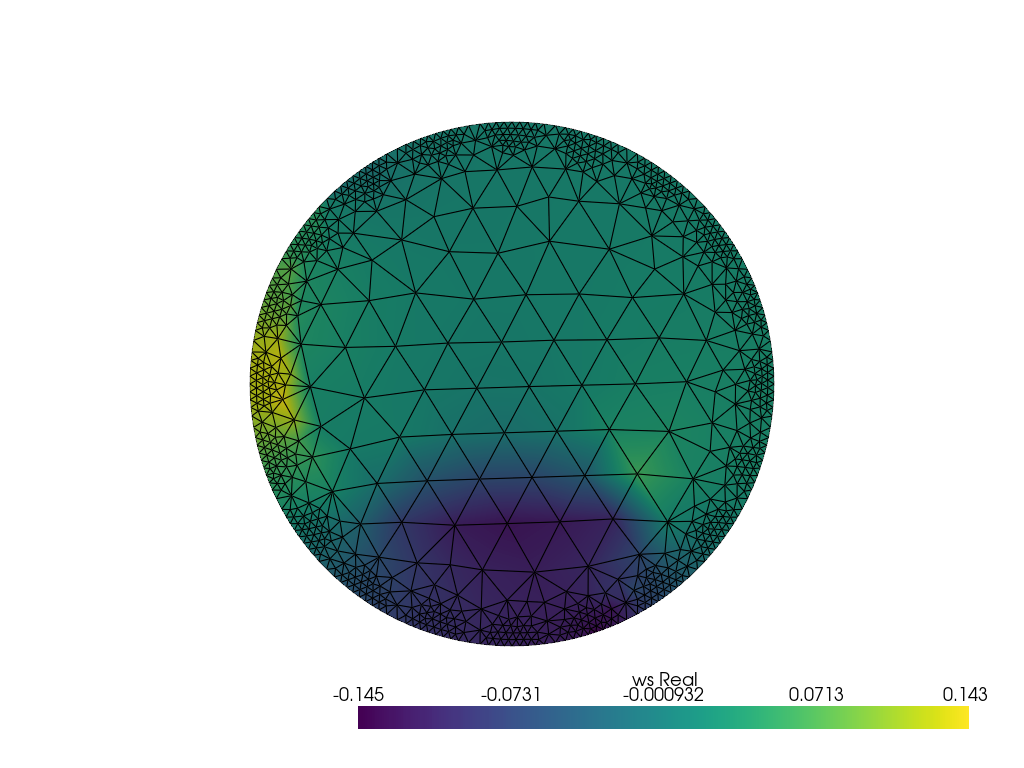

In [ ]:
grid.set_active_scalars("ws Real")
p_real = pyvista.Plotter(notebook=True)
# p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")


### Testing derivative - Spliting real and imaginary

Here, we use an alternative norm calculation. Instead of $L^2$ norm, we calculate the euclidian norm of each expansion array restricted to border $\overline u_s|_{\partial \Omega}, \overline u_{ex}|_{\partial \Omega} \in \mathbb R^N$.

In [ ]:
N = 60
err_array_real = np.zeros(N)
err_array_imag = np.zeros(N)
for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)
  expr = dolfinx.fem.Expression((fwd_F - bwd_F)/(2*t),V.element.interpolation_points())
  num_diff_Fi = dolfinx.fem.Function(V)
  num_diff_Fi.interpolate(expr)
  error = num_diff_Fi.x.array - ws.x.array
  error_bdr = error[boundary_dofs_index_array]
  norm_ws = np.linalg.norm(ws.x.array)
  err_array_real[i] = np.linalg.norm(error_bdr.real)/norm_ws
  err_array_imag[i] = np.linalg.norm(error_bdr.imag)/norm_ws

NameError: name 'boundary_dofs_index_array' is not defined

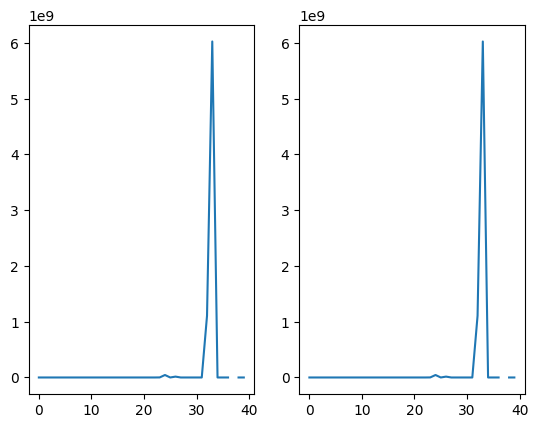

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(err_array_real[:40])
axes[1].plot(err_array_imag[:40])
plt.show()

In [ ]:
expr = dolfinx.fem.Expression((fwd_F - bwd_F)/(2*t),V.element.interpolation_points())
num_diff_Fi = dolfinx.fem.Function(V)
num_diff_Fi.interpolate(expr)

### Derivative Function



In [ ]:
def directionDerivate(gamma, us, eta):
  #Create Trial and test functions
  w = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  #creates object representing the gradient of w, us and v functions
  gradw = ufl.grad(w)
  gradv = ufl.grad(v)
  gradus = ufl.grad(us)

  dx = ufl.dx #object for domain infinitesimal entities (triangles)
  ds = ufl.ds # object for boundary infinitesimal entities (line segments)

  #Left gand side
  a = (gamma * ufl.inner(gradw, gradv)) * dx

  #Right hand side
  L = - (eta * ufl.inner(gradus,gradv)) * dx

  #Solving problem
  problem = dolfinx.fem.petsc.LinearProblem(a,L,jit_options={'timeout':20})
  ws = problem.solve()
  return ws

## Computing Adjoint

### Solve direct problem

In [50]:
#Solving direct problem (obtain us)
V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
V0 = dolfinx.fem.FunctionSpace(domain, ("DG", 0))
x = ufl.SpatialCoordinate(domain)
g = 4*x[1]**2 - 4*x[0]**2
gamma = dolfinx.fem.Function(V0,dtype=np.complex128)
gamma.x.array[:] = (1+1j)*np.ones_like(gamma.x.array)
us = solveDirect(gamma,g,V)

### Geometry experiments

In [51]:
adjacency_list = domain.topology.connectivity(2,0)
mesh_vertex_index_list = []
for i in range(len(adjacency_list)):
  mesh_vertex_index_list.append(adjacency_list.links(i))

In [ ]:
cells_coordinates_list = []
for cell_vertex_index in mesh_vertex_index_list:
  cells_coordinates_list.append(domain.geometry.x[cell_vertex_index][:,:2])

NameError: name 'mesh_vertex_index_list' is not defined

In [ ]:
mesh_vertex_index_list[0]

In [ ]:
cell0 = cells_coordinates_list[0]
print(cell0)

In [ ]:
#Calculations for a single triangle
system_array = np.concatenate((cell0,np.ones(3).reshape(3,1)),axis=1)
print("System matrix of the triangle:")
print(system_array)

u_t = us.x.array[mesh_vertex_index_list[0]]
print("U coordinates in triangle")
print(u_t)

plane_coef = np.linalg.solve(system_array,u_t)
print("Plane Coefficients")
print(plane_coef)

ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(cell0[:,0], cell0[:,1], u_t.real, linewidth=0.2, antialiased=True)
plt.show()

plane = lambda x, y : plane_coef[0]*x + plane_coef[1]*y + plane_coef[2]
plane_z = plane(cell0[:,0],cell0[:,1])
print(plane_z)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(cell0[:,0], cell0[:,1], plane_z, linewidth=0.2, antialiased=True)
plt.show()

In [ ]:
cell0

NameError: name 'cell0' is not defined

NameError: name 'mesh_vertex_index_list' is not defined

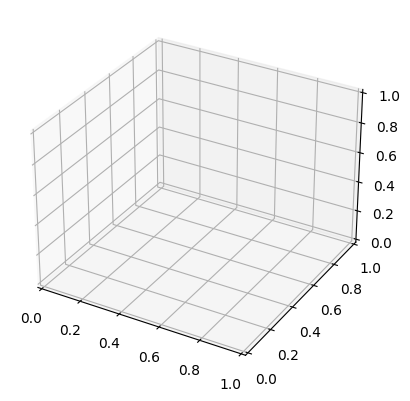

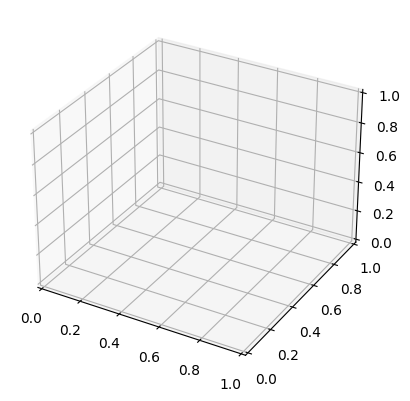

In [ ]:
# testing plot of planes to compare with function plot
ax = plt.figure().add_subplot(projection='3d')
ax1 = plt.figure().add_subplot(projection='3d')

for idx in mesh_vertex_index_list:
  cell_coord = domain.geometry.x[idx][:,:2]
  system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
  u_t = us.x.array[idx]
  ax.plot_trisurf(cell_coord[:,0], cell_coord[:,1], u_t.real, linewidth=0.2, antialiased=True)
  ax1.plot_trisurf(cell_coord[:,0], cell_coord[:,1], u_t.imag, linewidth=0.2, antialiased=True)

plt.show()

In [ ]:
gradu_list = []
for idx in mesh_vertex_index_list:
  cell_coord = domain.geometry.x[idx][:,:2]
  system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
  u_t = us.x.array[idx]
  plane_coef = np.linalg.solve(system_array, u_t)
  gradu_list.append(plane_coef[:2])

In [ ]:
gradu = np.array(gradu_list)

In [ ]:
#checking if the technique gets triangles in right order
#doing it calculating area by the coordinates from this method and by integrating elements
#then, compare them

area_list = []
for idx in mesh_vertex_index_list:
  cell_coord = domain.geometry.x[idx][:,:2]
  system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
  area = abs(np.linalg.det(system_array))/2
  area_list.append(area)
area_array = np.array(area_list)

# Obs: needs to compute only once
v = ufl.TrialFunction(V0)
cell_area_form = dolfinx.fem.form(v * ufl.dx)
cell_area = dolfinx.fem.assemble_vector(cell_area_form)
area_int_array = cell_area.array.real

print("Area by determinants",area_int_array)
print("Area by dolfin integration", area_array)
print("Error",np.linalg.norm(area_int_array-area_array))

Area by determinants [0.0003655  0.00037246 0.00037147 ... 0.00037754 0.00039367 0.00038964]
Area by dolfin integration [0.0003655  0.00037246 0.00037147 ... 0.00037754 0.00039367 0.00038964]
Error 7.854060272525775e-17


### Solving variational problem

In [53]:
#eta
eta = dolfinx.fem.Function(V, dtype=np.complex128) #create a null function in the space
eta.x.array[200:300] = 1+1j #define the vertex with set index as 1+j, rest remain as 0

psi = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

gradpsi = ufl.grad(psi)
gradv = ufl.grad(v)

#Left gand side
a = ufl.conj(gamma) * ufl.inner(gradpsi, gradv) * ufl.dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(eta,v) * ufl.ds

problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':30})
psisol = problem.solve()

In [54]:
print()

In [55]:
#Plotting eta
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["$\eta$ Real"] = eta.x.array.real
grid.point_data["$\eta$ Imaginary"] = eta.x.array.imag



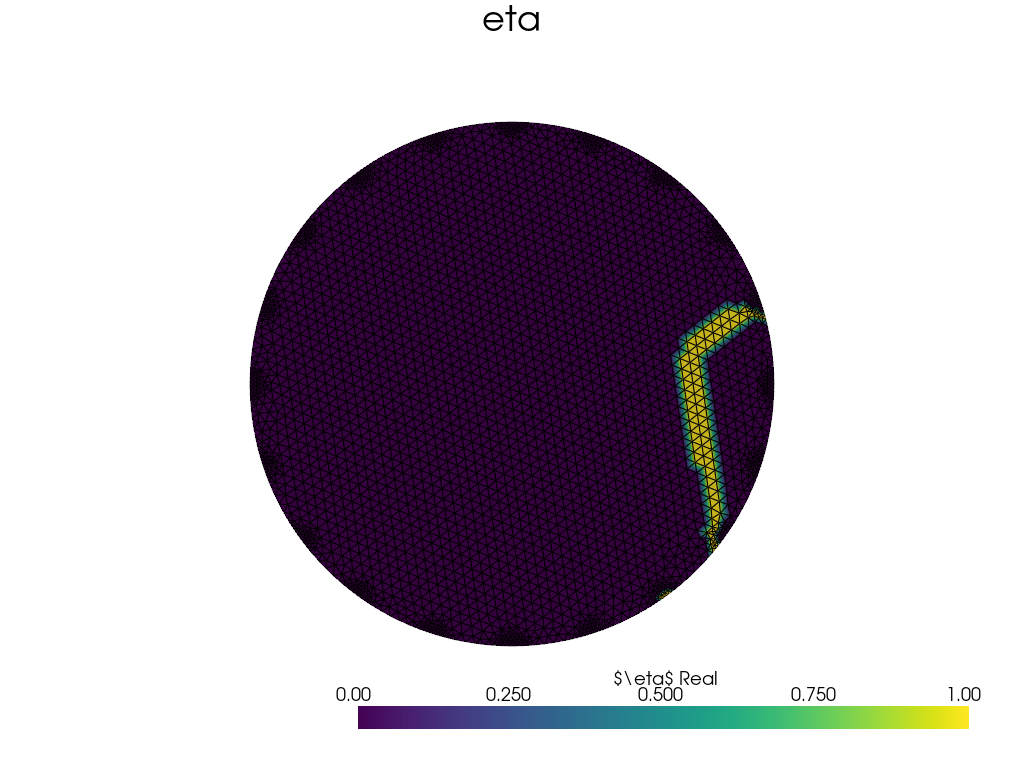

In [56]:

grid.set_active_scalars("$\eta$ Real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("eta", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")


### Comparing with the Jacobian



In [ ]:
#computing adjoint (\nabla u * \nabla psi in each coordinate)
grad_u = []
grad_psi = []
adjoint_list = []
for idx in mesh_vertex_index_list:
  cell_coord = domain.geometry.x[idx][:,:2]
  system_array = np.concatenate((cell_coord,np.ones(3).reshape(3,1)),axis=1)
  u_t = us.x.array[idx]
  psi_t = psisol.x.array[idx]
  plane_coef_u = np.linalg.solve(system_array, u_t)
  plane_coef_psi = np.linalg.solve(system_array, psi_t)
  gradu_t = plane_coef_u[:2]
  gradpsi_t = plane_coef_psi[:2]
  grad_u.append(gradu_t)
  grad_psi.append(gradu_t)
  adjoint_list.append(np.vdot(gradpsi_t,gradu_t))
adjoint = -np.array(adjoint_list)

In [ ]:
#Adjoint by jacobian hermitian
xi = dolfinx.fem.Function(V0, dtype=np.complex128)
M = xi.x.array.shape[0]
N = us.x.array.shape[0]
L=1

Jacobian = np.zeros((N,M),dtype=np.complex128)
for k in range(M):
  for j in range(L):
    xi.x.array[k] = 1
    Fxik = directionDerivate(gamma,us,xi)
    Jacobian[j:j+N,k] = Fxik.x.array
    xi.x.array[k] = 0


0.014070632902299318j

In [ ]:
#Applying hermitian (conjugated transpose) on eta
jacobianadjoint = Jacobian.T.conj() @ eta.x.array

In [ ]:
print(jacobianadjoint[:10])
print(adjoint[:10])

[-0.00095979+0.00095979j -0.00183607+0.00183607j -0.00267308+0.00267308j
 -0.00022805+0.00022805j -0.00228815+0.00228815j -0.00225881+0.00225881j
 -0.00525164+0.00525164j -0.00735845+0.00735845j -0.00103008+0.00103008j
 -0.00018487+0.00018487j]
[-0.01285043-0.01285043j -0.02602017-0.02602017j -0.0366357 -0.0366357j
 -0.00016169-0.00016169j -0.03381971-0.03381971j -0.03227931-0.03227931j
 -0.12145394-0.12145394j -0.11407934-0.11407934j -0.0175614 -0.0175614j
  0.00149789+0.00149789j]


In [ ]:
#comparison with the adjoint by jacobian
print((adjoint-jacobianadjoint)[0:10])
print(np.linalg.norm(adjoint-jacobianadjoint))

[-1.18906420e-02-0.01381022j -2.41840969e-02-0.02785624j
 -3.39626206e-02-0.03930878j  6.63579369e-05-0.00038974j
 -3.15315570e-02-0.03610786j -3.00204991e-02-0.03453811j
 -1.16202298e-01-0.12670558j -1.06720887e-01-0.12143779j
 -1.65313168e-02-0.01859148j  1.68275920e-03+0.00131303j]
27.85585561853834


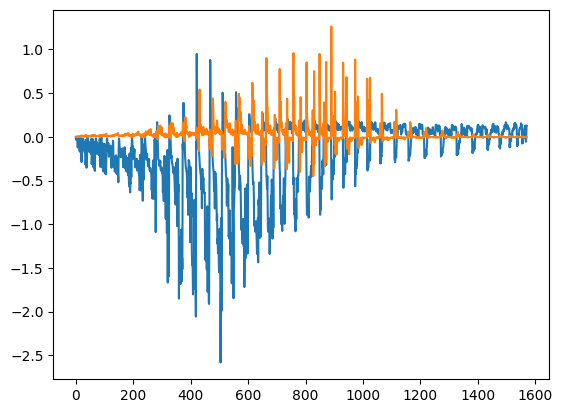

In [ ]:
plt.plot(adjoint.imag)
plt.plot(jacobianadjoint.imag)

### Testing fenicsx interpolation

Here, we interpolate the ufl expression `-ufl.inner(ufl.grad(us),ufl.grad(psisol))`, which corresponds to $-\nabla u \cdot \nabla \psi $ into `V0` space with Fenicsx functions.

In [ ]:
adj = dolfinx.fem.Function(V0,dtype=np.complex128)
expr = dolfinx.fem.Expression(-ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol))), V0.element.interpolation_points())
adj.interpolate(expr)

In [ ]:
e=-ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol)))
print(e)



-1 * (conj(((grad(f)) : (grad(f)))))


In [ ]:
adj.x.array

array([-0.01285043+0.01285043j, -0.02602017+0.02602017j,
       -0.0366357 +0.0366357j , ..., -0.00602414+0.00602414j,
        0.11407878-0.11407878j,  0.12710123-0.12710123j])

In [ ]:
np.linalg.norm(adj.x.array-adjoint)

38.02304308005387

In [ ]:
#Comparison with the adjoint computed by coordinates vectors
print(adjoint-adj.x.array)

[ 1.46722912e-14-0.02570086j  1.68490222e-13-0.05204034j
  1.05054854e-14-0.0732714j  ...  2.47657797e-14-0.01204828j
 -6.66133815e-15+0.22815757j  6.37268016e-14+0.25420245j]


In [ ]:
#comparison with the adjoint by jacobian
print(adj.x.array)
print(jacobianadjoint)
print(np.linalg.norm(adj.x.array-jacobianadjoint))

[-0.01285043+0.01285043j -0.02602017+0.02602017j -0.0366357 +0.0366357j
 ... -0.00602414+0.00602414j  0.11407878-0.11407878j
  0.12710123-0.12710123j]
[-0.00095979+0.00095979j -0.00183607+0.00183607j -0.00267308+0.00267308j
 ... -0.00060466+0.00060466j  0.00416001-0.00416001j
  0.00509586-0.00509586j]
25.20762339799133


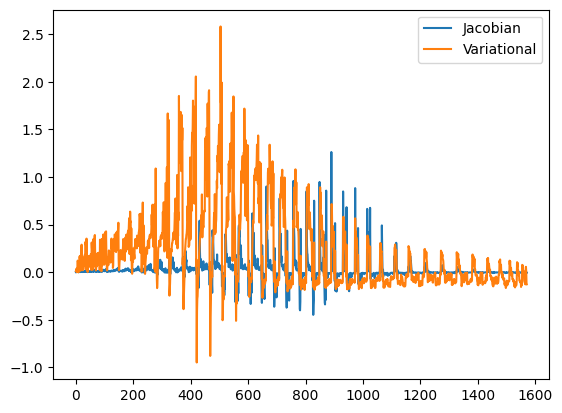

In [ ]:
plt.plot(jacobianadjoint.imag,label="Jacobian")
plt.plot(adj.x.array.imag,label="Variational")
plt.legend()
plt.show()


### Testing inner product

Here, we calculate the direct derivate $\omega = F'(\gamma)\nu$ for some $\nu\in L^\infty(\Omega)$ by the variational method. The objective is test the inner product property of adjoint:
$$
\langle F'(\gamma)\nu, \eta\rangle = \langle \nu, F'(\gamma)^* \eta \rangle
$$

In [59]:
adj = dolfinx.fem.Function(V0,dtype=np.complex128)
expr = dolfinx.fem.Expression(
    -ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol))),
    V0.element.interpolation_points()
    )
adj.interpolate(expr)

In [63]:
#computing nu
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
nu = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
nu.x.array[300:3000] = 5+3j
ws = directionDerivate(gamma,us,nu)


In [64]:
#Computing inner product between ws and eta
inner_H1 = dolfinx.fem.form(ufl.inner(ws,eta) * ufl.ds)
inner_H1_value = dolfinx.fem.assemble_scalar(inner_H1)

#Computing inner product between vu and adjoint
inner_Linf = dolfinx.fem.form(ufl.inner(nu,adj) * ufl.dx)
inner_Linf_value = dolfinx.fem.assemble_scalar(inner_Linf)

In [65]:
print(inner_H1_value)
print(inner_Linf_value)

print("Error:")
print(inner_H1_value - inner_Linf_value)

(-0.08737618050603399-0.3495047220241404j)
(-0.08694869604108305-0.3477947841643322j)
Error:
(-0.0004274844649509446-0.0017099378598082193j)


#### Testing between interpolated jacobians

In [57]:
#computing nu
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
nu = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
nu.x.array[900:950] = 1 #define the triangle with index 900 as 1, rest remain as 0


In [58]:
jacobianderivate = dolfinx.fem.Function(V,dtype=np.complex128)
jacobianderivate.x.array[:] = Jacobian @ nu.x.array

jacobianadjoint_fun = dolfinx.fem.Function(V0,dtype=np.complex128)
jacobianadjoint_fun.x.array[:] = jacobianadjoint


NameError: name 'Jacobian' is not defined

In [ ]:
#Computing inner product between ws and eta
inner_H1 = dolfinx.fem.form(ufl.inner(jacobianderivate,eta) * ufl.ds)
inner_H1_value = dolfinx.fem.assemble_scalar(inner_H1)

#Computing inner product between vu and adjoint
inner_Linf = dolfinx.fem.form(ufl.inner(nu,jacobianadjoint_fun) * ufl.dx)
inner_Linf_value = dolfinx.fem.assemble_scalar(inner_Linf)

In [ ]:
print(inner_H1_value)
print(inner_Linf_value)

(0.02139389380520709+0j)
(0.07720854741770435+0j)


### Adjoint Matrix

Analogue process for Jacobian, but computing each column by adjoint variational formulation

**Obs** non feasible, too long time for execution. Probably the problem is too high dimensional and take so much effort to solve

Also, the preconditionate system solver carries too much error to be compared

In [ ]:
#Adjoint by jacobian hermitian
V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
ei = dolfinx.fem.Function(V, dtype=np.complex128)
M = gamma.x.array.shape[0]

N = us.x.array.shape[0]

Adjoint = np.zeros((M,N),dtype=np.complex128)

psi = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)
gradpsi = ufl.grad(psi)
gradv = ufl.grad(v)
#Left gand side
a = ufl.conj(gamma) * ufl.inner(gradpsi, gradv) * ufl.dx #\int \nabla u * \overline \nabla v dx
A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(a))
solver = PETSc.KSP().create(domain.comm) #P().create(domain.comm)
solver.setOperators(A)

#Obs: below is for testing using direct solver
# Comment these lines for using default KSP iterative solver
A.assemble()

for k in range(N):
  print(k)
  ei.x.array[k] = 1
  psisol = dolfinx.fem.Function(V)
  L = ufl.inner(ei,v) * ufl.ds

  b  = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
  solver.solve(b,psisol.vector)

  adj = dolfinx.fem.Function(V0,dtype=np.complex128)
  expr = dolfinx.fem.Expression(-ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol))), V0.element.interpolation_points())
  adj.interpolate(expr)

  Adjoint[0:M,k] = adj.x.array
  ei.x.array[k] = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216


KeyboardInterrupt: 

In [ ]:
adjoint_iterp = dolfinx.fem.Function(V0,dtype=np.complex128)
expr = dolfinx.fem.Expression(-ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol))), V0.element.interpolation_points())
adjoint_iterp.interpolate(expr)

In [ ]:
adjoint_iterp.x.array

array([-0.01285043+0.01285043j, -0.02602017+0.02602017j,
       -0.0366357 +0.0366357j , ..., -0.00602414+0.00602414j,
        0.11407878-0.11407878j,  0.12710123-0.12710123j])

In [ ]:
Adjoint @ eta.x.array - adjoint_iterp.x.array

array([-0.04718711+0.04718711j,  0.64065564-0.64065564j,
        0.62511249-0.62511249j, ...,  0.61495891-0.61495891j,
        0.34755658-0.34755658j,  0.11306789-0.11306789j])

<a name="computing-jacobian"></a>

## Computing Jacobian
General proceeding:
- Create a generic function `xi` in `V0` space (discontinuos Garlekig degree 0). It will have a array of coefficients `xi.x.array` with size equal to number of dofs (cells)
- Iterate through every entry of `xi.x.array`, set as "1", then solve the derivative for it.


In [ ]:
x = ufl.SpatialCoordinate(domain)

V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
xi = dolfinx.fem.Function(V0, dtype=np.complex128)
M = xi.x.array.shape[0]

gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1+1j))
g = 4*x[1]**2 - 4*x[0]**2
V = dolfinx.fem.FunctionSpace(domain, ("CG",1))
us = solveDirect(gamma,g,V)

N = us.x.array.shape[0]
L=1

Jacobian = np.zeros((N,M),dtype=np.complex128)
for k in range(M):
  for j in range(L):
    xi.x.array[k] = 1
    Fxik = directionDerivate(gamma,us,xi)
    Jacobian[j:j+N,k] = Fxik.x.array

    xi.x.array[k] = 0


In [ ]:
M

1572

### Testing Jacobian

First test, fixed a given $\eta$, will compare $F'(\gamma)\eta$ calculated with the $\omega |_{\partial \Omega}$ get through variational formulation

In [ ]:
eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
eta.x.array[900:950] = 1+1j #define the triangle with index 900 as 1, rest remain as 0

ws = directionDerivate(gamma,us,eta)
jacobianeta = Jacobian @ eta.x.array

error = jacobianeta - ws.x.array
normerror = np.linalg.norm(error)
print(normerror)

9.811961724070266e-05


Next test is comparing with the numerical derivative. For this, we set a $t_k\to 0$ sequence and analyze the error:
$$
e_k = \left \| \frac{F_i(\gamma + t_k\eta) - F_i(\gamma -t_k \eta)}{2t} - F'(\gamma)\eta \right \|
$$

First, by norm $L_2$ in $\partial \Omega$. I.e., we create a function object `jacobianeta_func` in `V` space and set it coefficient array as the $F'(\gamma)\eta$ result. Next, we caculate the $L^2$ error through FEniCs integrals.

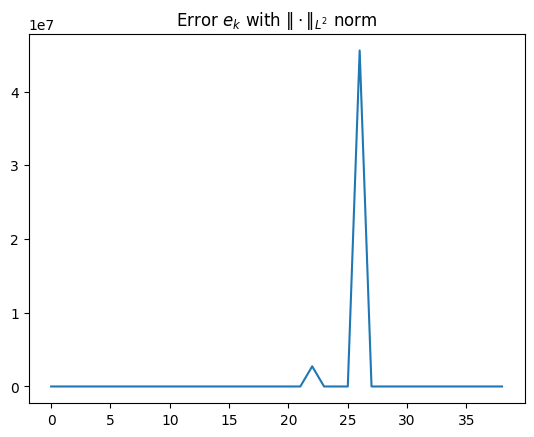

In [ ]:
N = 40

jacobianeta_func = dolfinx.fem.Function(V,dtype=np.complex128)
jacobianeta_func.x.array[:] = jacobianeta

err_array = np.zeros(N)
for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)
  num_diff_Fi = (fwd_F - bwd_F)/(2*t)

  error = num_diff_Fi - jacobianeta_func

  l2error = dolfinx.fem.form(ufl.inner(error,error) * ufl.ds)
  norm_ws = dolfinx.fem.form(ufl.inner(ws,ws) * ufl.ds)
  squareerror = dolfinx.fem.assemble_scalar(l2error)
  squarenorm = dolfinx.fem.assemble_scalar(norm_ws)
  l2normerror = np.sqrt(squareerror)
  squarenorm = np.sqrt(squarenorm)
  err_array[i] = l2normerror.real / squarenorm.real

plt.plot(err_array)
plt.title("Error $e_k$ with $\| \cdot \|_{L^2}$ norm")
plt.show()

Next, we split real and imaginary parts arrays.

In [ ]:
N = 30
err_array_real = np.zeros(N)
err_array_imag = np.zeros(N)

domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index

for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)

  num_diff_Fi = (fwd_F.x.array - bwd_F.x.array)/(2*t)
  error = num_diff_Fi - jacobianeta
  error_bdr = error[boundary_dofs_index_array]
  # norm_ws = np.linalg.norm(ws.x.array)
  err_array_real[i] = np.linalg.norm(error_bdr.real)
  err_array_imag[i] = np.linalg.norm(error_bdr.imag)

  num_diff_Fi = (fwd_F.x.array - bwd_F.x.array)/(2*t)



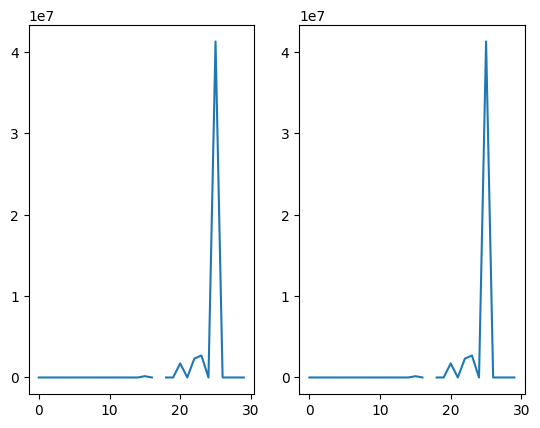

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(err_array_real[0:40])
axes[1].plot(err_array_imag[0:40])
plt.show()

### Jacobian Function

In [ ]:
def calcJacobian(gamma, U, I_all):
  """
  Calc jacobian assuming several currents

  Right now, it's getting the dimensions through the informed array structure
  Later, i'll set to treat it globally, using mesh info
  """
  # initial settings
  xi = dolfinx.fem.Function(V0, dtype=np.complex128) #create function for directions
  L = len(I_all)
  M = xi.x.array.shape[0] #number of triangles
  K = U[0].shape[0]

  N = K*L  #here is guessing the size of U matches K*L. TODO: think a better form

  Jacobian = np.zeros((N,M),dtype=np.complex128)
  #iterate through currents
  for j in range(L):
    u = dolfinx.fem.Function(V, dtype=np.complex128)
    u.x.array[:] = U[j]
    for k in range(M):
      xi.x.array[k] = 1
      Fxik = directionDerivate(gamma,u,xi)
      Jacobian[j*K:(j+1)*K,k] = Fxik.x.array
      xi.x.array[k] = 0
  return Jacobian

# I_array = [4*x[1]**2 - 4*x[0]**2]
jacobianfunc = calcJacobian(gamma,U_list,I_all)

NameError: ignored

In [ ]:
jacobianfunc1 = calcJacobian(gamma, [us.x.array],[g])

## Solving for different currents


### Setting different currents

First tests will be done defining "rotations" of the current $g$ given by
$$
g(x,y) = 4y^2 - 4x^2
$$

We perform this setting a rotation parameter $\theta$ then applying it to the rotated axis $x' = x \cos(\theta) + y \sin (\theta), y'= -x\sin (\theta) + y \cos (\theta)$, defining:
$$
g_\theta(x,y)  = 4(-x\sin (\theta) + y \cos (\theta))^2 - 4(x \cos(\theta) + y \sin (\theta))^2
$$

  scalars = scalars.astype(float)



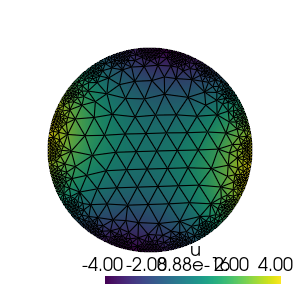

In [ ]:
# First test
x = ufl.SpatialCoordinate(domain)
theta = 1.4
gtheta_expr = 4*(-x[0]*np.sin(theta) + x[1]*np.cos(theta))**2 - 4*(x[0]*np.cos(theta)+x[1]*np.sin(theta))**2
expr = dolfinx.fem.Expression(gtheta_expr, V.element.interpolation_points())
gtheta = dolfinx.fem.Function(V)
gtheta.interpolate(expr)

plot_vertex_function(ginterp.x.array,V)

In [ ]:
def solveDirect(gamma,g,V):
  #Left gand side
    u = ufl.TrialFunction(V) #function u_h
    v = ufl.TestFunction(V)

    gradu = ufl.grad(u)
    gradv = ufl.grad(v)

    #Left gand side
    a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

    #Right hand side
    L = ufl.inner(g,v) * ds

    problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':20})
    usol = problem.solve()
    return usol


  scalars = scalars.astype(float)



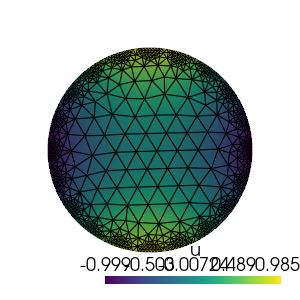

  scalars = scalars.astype(float)



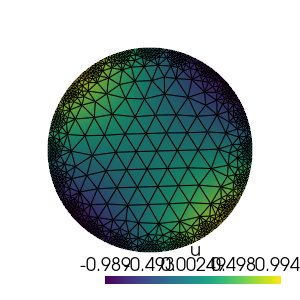

  scalars = scalars.astype(float)



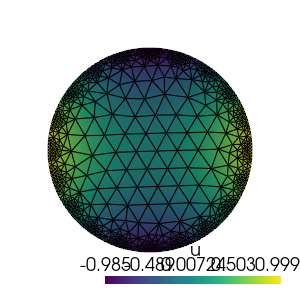

  scalars = scalars.astype(float)



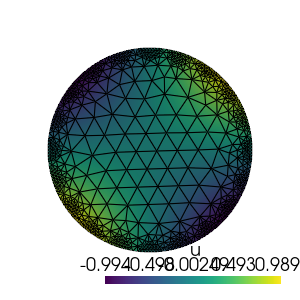

  scalars = scalars.astype(float)



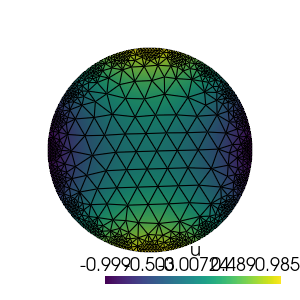

In [ ]:
#Solving problem for gtheta
theta_array = np.linspace(0,np.pi, 5)
for theta in theta_array:
  gtheta = 4*(-x[0]*np.sin(theta) + x[1]*np.cos(theta))**2 - 4*(x[0]*np.cos(theta)+x[1]*np.sin(theta))**2

  ustheta = solveDirect(gamma,gtheta,V)
  plot_vertex_function(ustheta.x.array,V)


### Get different current solutions

In [ ]:
# Defining current array
I_all = []
theta_array = np.linspace(0,np.pi/2,8)
for theta in theta_array:
  I_all.append(4*(-x[0]*np.sin(theta) + x[1]*np.cos(theta))**2 - 4*(x[0]*np.cos(theta)+x[1]*np.sin(theta))**2)

u_sol_array = []
for g in I_all:
  ustheta = solveDirect(gamma,g,V)
  u_sol_array.append(ustheta.x.array)


In [ ]:
def solveDirectOperator(gamma,I_all,V):
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

  u_sol_array = []
  #Right hand side
  for g in I_all:
    L = ufl.inner(g,v) * ds
    problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':20})
    usol = problem.solve()
    u_sol_array.append(usol.x.array)

  return u_sol_array


In [ ]:
U_list = solveDirectOperator(gamma,I_all, V)

In [ ]:
U_list[0]

array([ 0.98313182-0.98313182j,  0.93603598-0.93603598j,
        0.98491836-0.98491836j,  0.93530496-0.93530496j,
        0.9830846 -0.9830846j ,  0.93262942-0.93262942j,
        0.93048428-0.93048428j,  0.97763781-0.97763781j,
        0.81593169-0.81593169j,  0.7656678 -0.7656678j ,
        0.78112324-0.78112324j,  0.8476005 -0.8476005j ,
        0.78063491-0.78063491j,  0.8893419 -0.8893419j ,
        0.97775227-0.97775227j,  0.88898579-0.88898579j,
        0.88609867-0.88609867j,  0.92102346-0.92102346j,
        0.72902118-0.72902118j,  0.82261126-0.82261126j,
        0.74345922-0.74345922j,  0.87627902-0.87627902j,
        0.31087161-0.31087161j,  0.2688274 -0.2688274j ,
        0.25390458-0.25390458j,  0.32150062-0.32150062j,
        0.92052189-0.92052189j,  0.88196446-0.88196446j,
        0.87598692-0.87598692j,  0.96864374-0.96864374j,
        0.72264258-0.72264258j,  0.77017809-0.77017809j,
        0.84750491-0.84750491j,  0.68839773-0.68839773j,
        0.84635037-0.84635037j,

## Testing calc by assembling matrices

Through the current process, we mount the linear system and solve with:
```
a = (gamma * ufl.inner(gradu, gradv)) * dx
L = ...
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()
```

Problem is that it needs to mount the system and solve it each time, which takes too long when needed to solve direct problem several times.

Following tests are for solving through matrices. With this, we can reuse `A = assemble(a)` inverse or factorizations for next calcs.

Reference: https://jsdokken.com/dolfinx-tutorial/chapter4/newton-solver.html

In [ ]:
x = ufl.SpatialCoordinate(domain)
g = 4*x[1]**2 - 4*x[0]**2

V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))

u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#creates object representing the gradient of u and v functions
gradu = ufl.grad(u)
gradv = ufl.grad(v)

dx = ufl.dx #object for domain infinitesimal entities (triangles)
ds = ufl.ds # object for boundary infinitesimal entities (line segments)

#Left gand side
a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ds

#Obs: inner product is set to consider the conjugate in second term

In [ ]:
a_comp = dolfinx.fem.form(a)
L_comp = dolfinx.fem.form(L)
# A = dolfinx.fem.petsc.create_matrix(a_comp)
A = dolfinx.fem.petsc.assemble_matrix(a_comp)
b = dolfinx.fem.petsc.assemble_vector(L_comp)

In [ ]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
# solver.setType("preonly")
# solver.getPC().setType('lu')

In [ ]:
# solver.setType(PETSc.KSP.Type.PREONLY)
# solver.getPC().setType(PETSc.PC.Type.LU)
# solver.setFromOptions()

In [ ]:
u = dolfinx.fem.Function(V)
A.assemble()
solver.solve(b,u.vector)


In [ ]:
#Solving through LinearProblem
# problem = dolfinx.fem.petsc.LinearProblem(a,L,petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

In [ ]:
#Comparing solutions
print("Norm of difference:",np.linalg.norm(us.x.array-u.x.array))

Norm of difference: 0.0


In [ ]:
#Compare with exact solution
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))
uex = dolfinx.fem.Function(V2, dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

l2error = dolfinx.fem.form(ufl.inner(u-uex,u-uex) * ufl.dx)
squareerror = dolfinx.fem.assemble_scalar(l2error)

l2normerror = np.sqrt(squareerror)
max_error = np.max(np.abs(squareerror))

print("L2 norm error: ", l2normerror)
print("Max error: ",max_error)

L2 norm error:  (0.021236688289532443+0j)
Max error:  0.00045099692950676437


In [ ]:
#Compare with exact solution
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))
uex = dolfinx.fem.Function(V2, dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

l2error = dolfinx.fem.form(ufl.inner(us-uex,us-uex) * ufl.dx)
squareerror = dolfinx.fem.assemble_scalar(l2error)

l2normerror = np.sqrt(squareerror)
max_error = np.max(np.abs(squareerror))

print("L2 norm error: ", l2normerror)
print("Max error: ",max_error)

L2 norm error:  (0.021236688289532443+0j)
Max error:  0.00045099692950676437


### Jacobian calc through matrices

In [ ]:
def calcJacobianMatrix(gamma, U, I_all):
  """
  Calc jacobian assuming several currents

  Right now, it's getting the dimensions through the informed array structure
  Later, i'll set to treat it globally, using mesh info

  gamma:  dolfinx function or expression
  U:      list of u_sol fem function objects
  I_all:  list of currents g_i defined as expressions or fem functions
  """
  # initial settings
  V = U[0].function_space

  xi = dolfinx.fem.Function(gamma.function_space, dtype=np.complex128) #create function for directions
  L = len(I_all)
  M = xi.x.array.shape[0] #number of triangles
  K = V.dofmap.index_map.size_global #number of vertex (dofs)
  # K = U[0].x.array.shape[0] #number of vertex

  N = K*L  #here is guessing the size of U matches K*L. TODO: think a better form

  Jacobian = np.zeros((N,M),dtype=np.complex128)

  # V = us.function_space
  w = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  #creates object representing the gradient of w, us and v functions
  gradw = ufl.grad(w)
  gradv = ufl.grad(v)
  a = (gamma * ufl.inner(gradw, gradv)) * ufl.dx
  A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(a))

  solver = PETSc.KSP().create(domain.comm) #P().create(domain.comm)
  solver.setOperators(A)

  #Obs: below is for testing using direct solver
  # Comment these lines for using default KSP iterative solver
  # solver.setType("preonly")
  # solver.getPC().setType('lu')

  A.assemble()

  ws = dolfinx.fem.Function(V)
  #iterate through currents
  for j in range(L):
    us = U[j]
    gradus = ufl.grad(us)
    print("Starting calc for current",j)
    t1 = time.time()
    for k in range(M):
      xi.x.array[k] = 1
      # Fxik = directionDerivate(gamma,u,xi)
      L = - (xi * ufl.inner(gradus,gradv)) * ufl.dx
      b  = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
      solver.solve(b,ws.vector)
      Jacobian[j*K:(j+1)*K,k] = ws.x.array
      xi.x.array[k] = 0
    t2= time.time()
    print("Solved directional derivative in ", t2-t1,"s")
  return Jacobian

Next, comparing with the Jacobian calculated in [Computing Jacobian](#computing-jacobian)

In [ ]:
x = ufl.SpatialCoordinate(domain)

V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
xi = dolfinx.fem.Function(V0, dtype=np.complex128)
M = xi.x.array.shape[0]

# gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1+1j))
gamma = dolfinx.fem.Function(V0)
gamma.x.array[:] = (1+1j)*np.ones_like(gamma.x.array)
g = 4*x[1]**2 - 4*x[0]**2
V = dolfinx.fem.FunctionSpace(domain, ("CG",1))
us = solveDirect(gamma,g,V)

N = us.x.array.shape[0]
L=1



In [ ]:
%%time
Jacobian = np.zeros((N,M),dtype=np.complex128)
for k in range(M):
  for j in range(L):
    xi.x.array[k] = 1
    # Fxik = directionDerivate(gamma,us,xi)
    w = ufl.TrialFunction(V) #function u_h
    v = ufl.TestFunction(V)

    #creates object representing the gradient of w, us and v functions
    gradw = ufl.grad(w)
    gradv = ufl.grad(v)
    gradus = ufl.grad(us)

    dx = ufl.dx #object for domain infinitesimal entities (triangles)
    #Left gand side
    a = (gamma * ufl.inner(gradw, gradv)) * dx

    #Right hand side
    rhs = - (xi * ufl.inner(gradus,gradv)) * dx

    #Solving problem
    problem = dolfinx.fem.petsc.LinearProblem(a,rhs,jit_options={'timeout':20})
    Fxik = problem.solve()

    Jacobian[j:j+N,k] = Fxik.x.array

    xi.x.array[k] = 0


CPU times: user 17.3 s, sys: 429 ms, total: 17.7 s
Wall time: 17.8 s


In [ ]:
%%time
J1 = calcJacobianMatrix(gamma,[us],[g])

Starting calc for current 0
Solved directional derivative in  9.607185363769531 s
CPU times: user 9.33 s, sys: 195 ms, total: 9.52 s
Wall time: 9.63 s


In [ ]:
%%time
#Comparing with Jacobian with preconditionate matrices
I_all = [g]
U = [us]
xi = dolfinx.fem.Function(gamma.function_space, dtype=np.complex128) #create function for directions
L = len(I_all)
M = xi.x.array.shape[0] #number of triangles
K = V.dofmap.index_map.size_global #number of vertex (dofs)
# K = U[0].x.array.shape[0] #number of vertex

N = K*L  #here is guessing the size of U matches K*L. TODO: think a better form

J2 = np.zeros((N,M),dtype=np.complex128)

# V = us.function_space
w = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

#creates object representing the gradient of w, us and v functions
gradw = ufl.grad(w)
gradv = ufl.grad(v)
a = (gamma * ufl.inner(gradw, gradv)) * ufl.dx
A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(a))

solver = PETSc.KSP().create(domain.comm) #P().create(domain.comm)
solver.setOperators(A)

#Obs: below is for testing using direct solver
# Comment these lines for using default KSP iterative solver
solver.setType("preonly")
solver.getPC().setType('lu')

A.assemble()

ws = dolfinx.fem.Function(V)
#iterate through currents
for j in range(L):
  gradus = ufl.grad(us)
  print("Starting calc for current",j)
  t1 = time.time()
  for k in range(M):
    xi.x.array[k] = 1
    # Fxik = directionDerivate(gamma,u,xi)
    L = - (xi * ufl.inner(gradus,gradv)) * ufl.dx
    b  = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
    solver.solve(b,ws.vector)
    J2[j*K:(j+1)*K,k] = ws.x.array
    xi.x.array[k] = 0
  t2= time.time()
  print("Solved directional derivative in ", t2-t1,"s")

Starting calc for current 0
Solved directional derivative in  2.902698040008545 s
CPU times: user 2.76 s, sys: 136 ms, total: 2.89 s
Wall time: 2.91 s


In [ ]:
#Comparing through norm
print("Default x assembled", np.linalg.norm(Jacobian - J1))
print("Default x preconditionate", np.linalg.norm(Jacobian - J2))
print("Assembled x preconditionate",np.linalg.norm(J2-J1))

Default x assembled 0.0
Default x preconditionate 2.275308118773421
Assembled x preconditionate 2.275308118773421


### Comparing with some direction

In [ ]:
eta = dolfinx.fem.Function(V0,dtype=np.complex128)
eta.x.array[200:500] = 1+1j

In [ ]:
eta+=eta
eta.x.array

AttributeError: 'Sum' object has no attribute 'x'

In [ ]:
J1 @ eta.x.array - J2 @ eta.x.array

5.821619162483958

### Jacobian numerical test

In [ ]:
###

In [ ]:
eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
eta.x.array[900:910] = 1+1j #define the triangle with index 900 as 1, rest remain as 0

ws = directionDerivate(gamma,us,eta)
jacobianeta = J1 @ eta.x.array

error = jacobianeta - ws.x.array
normerror = np.linalg.norm(error)
print(normerror)

1.7457644335595495e-05


Next test is comparing with the numerical derivative. For this, we set a $t_k\to 0$ sequence and analyze the error:
$$
e_k = \left \| \frac{F_i(\gamma + t_k\eta) - F_i(\gamma -t_k \eta)}{2t} - F'(\gamma)\eta \right \|
$$

First, by norm $L_2$ in $\partial \Omega$. I.e., we create a function object `jacobianeta_func` in `V` space and set it coefficient array as the $F'(\gamma)\eta$ result. Next, we caculate the $L^2$ error through FEniCs integrals.

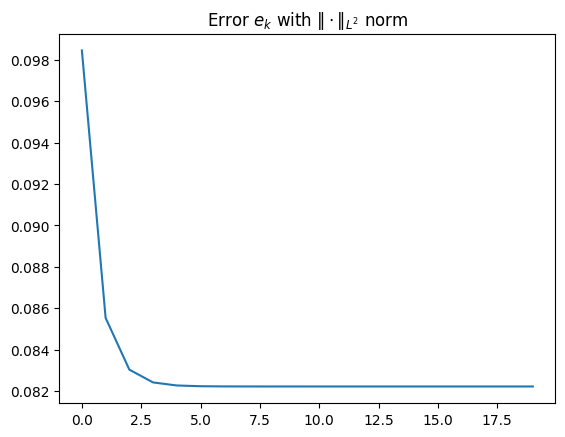

In [ ]:
N = 20

jacobianeta_func = dolfinx.fem.Function(V,dtype=np.complex128)
jacobianeta_func.x.array[:] = jacobianeta

err_array = np.zeros(N)
for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)
  num_diff_Fi = (fwd_F - bwd_F)/(2*t)

  error = num_diff_Fi - jacobianeta_func

  l2error = dolfinx.fem.form(ufl.inner(error,error) * ufl.ds)
  norm_ws = dolfinx.fem.form(ufl.inner(ws,ws) * ufl.ds)
  squareerror = dolfinx.fem.assemble_scalar(l2error)
  squarenorm = dolfinx.fem.assemble_scalar(norm_ws)
  l2normerror = np.sqrt(squareerror)
  squarenorm = np.sqrt(squarenorm)
  err_array[i] = l2normerror.real #/ squarenorm.real

plt.plot(err_array)
plt.title("Error $e_k$ with $\| \cdot \|_{L^2}$ norm")
plt.show()

In [ ]:

err_array

array([8.47630536e-02, 8.31512413e-02, 8.30774836e-02, 8.30714187e-02,
       8.30706279e-02, 8.30704725e-02, 8.30704363e-02, 8.30704274e-02,
       8.30704251e-02, 8.30704246e-02, 8.30704245e-02, 7.89841899e+01,
       8.30704244e-02, 8.30704244e-02, 1.64593721e+04, 1.73017151e+04,
       8.30704244e-02, 8.30704228e-02, 8.30704243e-02, 8.30704225e-02])

## Testing correction factor

In the process of solving $$A u = L$$, there is an infinite ammount of solutions, where one of minimal norm is selected.

Since the kernel $\mathcal N(A)$ is the space of constant functions, given $\hat u$ the solution found, every other solution is in the form $u = \hat u + c$, for some $c\in \mathbb R$.

However, we usually add an restriction for imposing:
$$
\int_{\partial \Omega} u dx= 0
$$


After some math, we may show that given some $\hat u$ found, the solution satisfying $\int_{\partial \Omega} \overline u =0$  is given with the $c$ correction factor:

$$
\overline u = \hat u + c = \hat u - \frac{1}{|\partial \Omega|}\int_{\partial \Omega} \hat udx
$$
where $|\partial \Omega|$ is the measure of $\partial \Omega$. In our case, of the unitary disk, we have $|\partial \Omega| = 2\pi$



In [ ]:
x = ufl.SpatialCoordinate(domain)
g = 4*x[1]**2 - 4*x[0]**2

V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))

u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#creates object representing the gradient of u and v functions
gradu = ufl.grad(u)
gradv = ufl.grad(v)
dx = ufl.dx #object for domain infinitesimal entities (triangles)
ds = ufl.ds # object for boundary infinitesimal entities (line segments)

#Left gand side
a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ds

In [ ]:
a_comp = dolfinx.fem.form(a)
L_comp = dolfinx.fem.form(L)
A = dolfinx.fem.petsc.assemble_matrix(a_comp)
b = dolfinx.fem.petsc.assemble_vector(L_comp)
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)

# Default solution
us = dolfinx.fem.Function(V)
A.assemble()
solver.solve(b,us.vector)

In [ ]:
# Creating solution adding correction factor
u_int_form = dolfinx.fem.form(us * ufl.ds)
u_int = dolfinx.fem.assemble_scalar(u_int_form)
c= -u_int/(2*np.pi)

u_corr = dolfinx.fem.Function(V)
u_corr.x.array[:] = us.x.array + c

### Comparing error

In [ ]:
# Defining exact solution
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))
uex = dolfinx.fem.Function(V2, dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

l2error_def = dolfinx.fem.form(ufl.inner(us-uex,us-uex) * ufl.dx)
squareerror_def = dolfinx.fem.assemble_scalar(l2error_def)
l2normerror_def = np.sqrt(squareerror_def)
max_error_def = np.max(np.abs(squareerror_def))

l2error_corr = dolfinx.fem.form(ufl.inner(u_corr-uex,u_corr-uex) * ufl.dx)
squareerror_corr = dolfinx.fem.assemble_scalar(l2error_corr)
l2normerror_corr = np.sqrt(squareerror_corr)
max_error_corr = np.max(np.abs(squareerror_corr))


print("L2 norm error (default): ", l2normerror_def)
print("Max error (default): ",max_error_def)

print("L2 norm error (corrected): ", l2normerror_corr)
print("Max error: (corrected)",max_error_corr)

L2 norm error (default):  (0.021236688289532443+0j)
Max error (default):  0.00045099692950676437
L2 norm error (corrected):  (0.011567495476932583+0j)
Max error: (corrected) 0.00013380695160885577


### Comparing Boundary Error

In [ ]:
# Defining exact solution
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))
uex = dolfinx.fem.Function(V2, dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

l2error_def = dolfinx.fem.form(ufl.inner(us-uex,us-uex) * ufl.ds)
squareerror_def = dolfinx.fem.assemble_scalar(l2error_def)
l2normerror_def = np.sqrt(squareerror_def)
max_error_def = np.max(np.abs(squareerror_def))

l2error_corr = dolfinx.fem.form(ufl.inner(u_corr-uex,u_corr-uex) * ufl.ds)
squareerror_corr = dolfinx.fem.assemble_scalar(l2error_corr)
l2normerror_corr = np.sqrt(squareerror_corr)
max_error_corr = np.max(np.abs(squareerror_corr))


print("L2 bdr norm error (default): ", l2normerror_def)
print("Max bdr error (default): ",max_error_def)

print("L2 bdr norm error (corrected): ", l2normerror_corr)
print("Max bdr error: (corrected)",max_error_corr)

L2 bdr norm error (default):  (0.03280072285243578+0j)
Max bdr error (default):  0.0010758874196423029
L2 bdr norm error (corrected):  (0.021115826607389948+0j)
Max bdr error: (corrected) 0.00044587813331335724


In [ ]:
sorted_theta_index = get_boundary_index(V)
t = get_boundary_theta_array(V)

f = lambda t: np.cos(t)**2 - np.sin(t)**2
u_bdr =  get_boundary_data(domain, us, V)
u_corr_bdr = get_boundary_data(domain, u_corr, V)

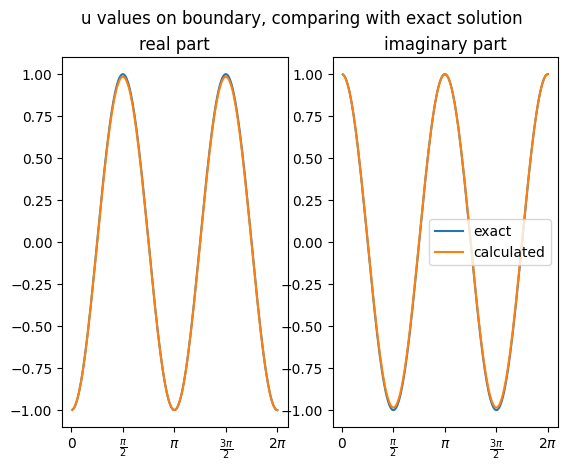

In [ ]:
fig,axs = plt.subplots(1,2)

axs[0].plot(t,-f(t),label="exact")
axs[0].plot(t,u_bdr.real,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(t,f(t),label="exact")
axs[1].plot(t,u_bdr.imag,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary (no correction), comparing with exact solution")
plt.legend()
plt.show()

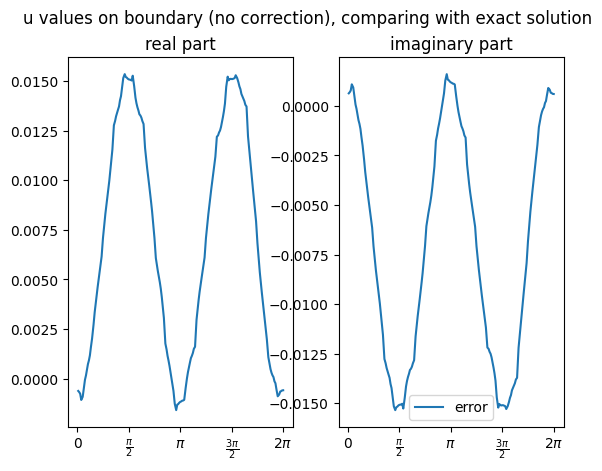

In [ ]:
fig,axs = plt.subplots(1,2)

axs[0].plot(t,-f(t)-u_bdr.real,label="error")
# axs[0].plot(t,u_bdr.real,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(t,f(t)-u_bdr.imag,label="error")
# axs[1].plot(t,u_bdr.imag,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary (no correction), comparing with exact solution")
plt.legend()
plt.show()

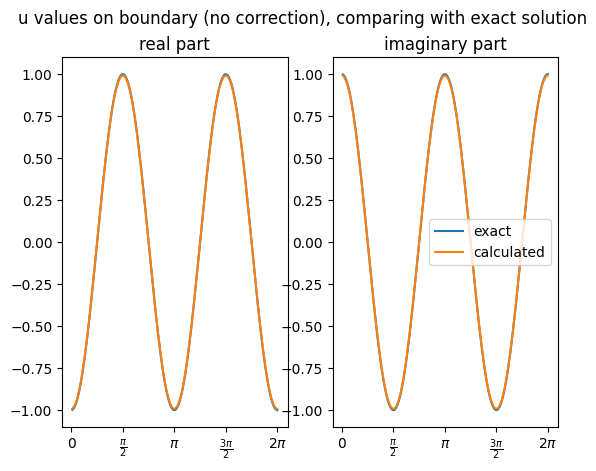

In [ ]:
fig,axs = plt.subplots(1,2)

axs[0].plot(t,-f(t),label="exact")
axs[0].plot(t,u_corr_bdr.real,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(t,f(t),label="exact")
axs[1].plot(t,u_corr_bdr.imag,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary (no correction), comparing with exact solution")
plt.legend()
plt.show()

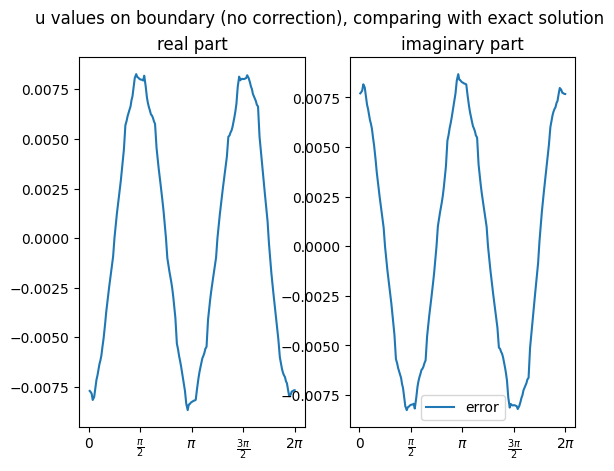

In [ ]:
fig,axs = plt.subplots(1,2)

axs[0].plot(t,-f(t)-u_corr_bdr.real,label="error")
# axs[0].plot(t,u_corr_bdr.real,label="calculated")
axs[0].set_title("real part")
axs[0].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])

axs[1].plot(t,f(t)-u_corr_bdr.imag,label="error")
# axs[1].plot(t,u_corr_bdr.imag,label="calculated")
axs[1].set_title("imaginary part")
axs[1].set_xticks(np.linspace(0,2*np.pi,5),["0","$\\frac{\pi}{2}$","$\pi$","$\\frac{3\pi}{2}$","$2\pi$"])
fig.suptitle("u values on boundary (no correction), comparing with exact solution")
plt.legend()
plt.show()

### Testing derivative with correction

In [ ]:
def solveDirect(gamma,g,V):
#Left gand side
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

  #Right hand side
  L = ufl.inner(g,v) * ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':20})
  usol = problem.solve()

  usol_int_form = dolfinx.fem.form(usol * ufl.ds)
  usol_int = dolfinx.fem.assemble_scalar(usol_int_form)
  c = -usol_int/(2*np.pi)
  usol.x.array[:] += c
  return usol

In [ ]:
V0 = dolfinx.fem.FunctionSpace(domain, ("DG",0))
eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space
eta.x.array[900:950] = 1+1j #define the triangle with index 900 as 1, rest remain as 0

ws = directionDerivate(gamma,u_corr,eta)

In [ ]:
ws_int_form = dolfinx.fem.form(ws * ufl.ds)
ws_int = dolfinx.fem.assemble_scalar(ws_int_form)
c= -ws_int/(2*np.pi)

ws_corr = dolfinx.fem.Function(V)
ws_corr.x.array[:] = ws.x.array + c

In [ ]:
N = 60
err_array_real = np.zeros(N)
err_array_imag = np.zeros(N)
err_corr_array_real = np.zeros(N)
err_corr_array_imag = np.zeros(N)

for i in range(N):
  t = 1/2**i
  fwd_F = solveDirect(gamma+t*eta, g, V)
  bwd_F = solveDirect(gamma-t*eta, g, V)
  num_diff_Fi = (fwd_F.x.array - bwd_F.x.array)/(2*t)

  error = num_diff_Fi - ws.x.array
  error_bdr = error[sorted_theta_index]
  norm_ws = np.linalg.norm(ws.x.array)
  err_array_real[i] = np.linalg.norm(error_bdr.real)/norm_ws
  err_array_imag[i] = np.linalg.norm(error_bdr.imag)/norm_ws

  error = num_diff_Fi - ws_corr.x.array
  error_bdr = error[sorted_theta_index]
  norm_ws_corr = np.linalg.norm(ws_corr.x.array)
  err_corr_array_real[i] = np.linalg.norm(error_bdr.real)/norm_ws_corr
  err_corr_array_imag[i] = np.linalg.norm(error_bdr.imag)/norm_ws_corr

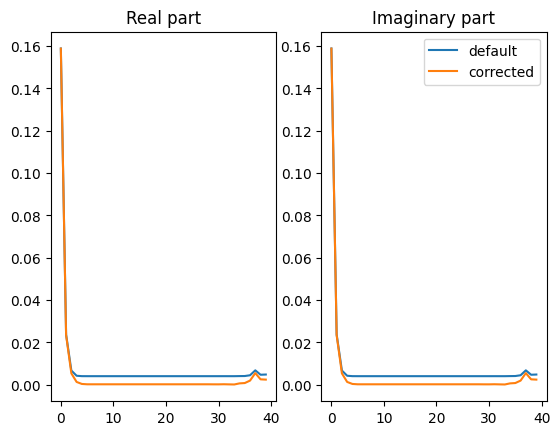

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(err_array_real[:40],label="default")
axes[0].plot(err_corr_array_real[:40],label="corrected")
axes[0].set_title("Real part")
axes[1].plot(err_array_imag[:40],label='default')
axes[1].plot(err_corr_array_imag[:40],label="corrected")
axes[1].set_title("Imaginary part")
# fig.suptitle("No correction")
plt.legend()
plt.show()

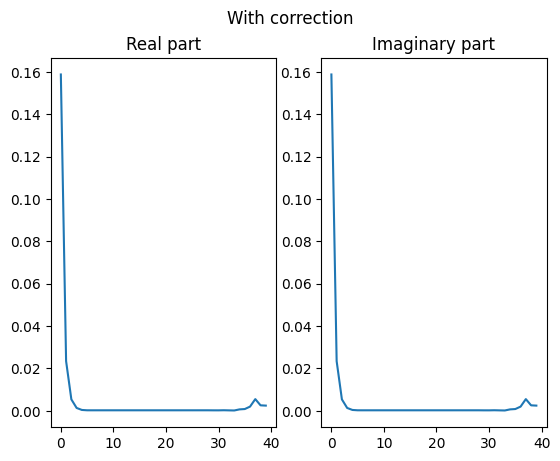

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(err_corr_array_real[:40])
axes[0].set_title("Real part")
axes[1].plot(err_corr_array_imag[:40])
axes[1].set_title("Imaginary part")
fig.suptitle("With correction")
plt.show()

# Implementation - inverse problem



## Auxiliar Functions

In [6]:
def calcJacobianMatrix(gamma, U, I_all):
  """
  Calc jacobian assuming several currents

  Right now, it's getting the dimensions through the informed array structure
  Later, i'll set to treat it globally, using mesh info

  gamma:  dolfinx function or expression
  U:      list of u_sol fem function objects
  I_all:  list of currents g_i defined as expressions or fem functions
  """
  # initial settings
  V = U[0].function_space
  domain = V.mesh

  xi = dolfinx.fem.Function(gamma.function_space, dtype=np.complex128) #create function for directions
  L = len(I_all)
  M = xi.x.array.shape[0] #number of triangles
  K = V.dofmap.index_map.size_global #number of vertex (dofs)
  # K = U[0].x.array.shape[0] #number of vertex

  N = K*L  #here is guessing the size of U matches K*L. TODO: think a better form

  Jacobian = np.zeros((N,M),dtype=np.complex128)

  # V = us.function_space
  w = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  #creates object representing the gradient of w, us and v functions
  gradw = ufl.grad(w)
  gradv = ufl.grad(v)
  a = (gamma * ufl.inner(gradw, gradv)) * ufl.dx
  A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(a))

  solver = PETSc.KSP().create(domain.comm) #P().create(domain.comm)
  solver.setOperators(A)

  #Obs: below is for testing using direct solver
  # Comment these lines for using default KSP iterative solver
  # solver.setType("preonly")
  # solver.getPC().setType('lu')

  A.assemble()

  ws = dolfinx.fem.Function(V)
  #iterate through currents
  for j in range(L):
    us = U[j]
    gradus = ufl.grad(us)
    print("Starting calc for current",j)
    t1 = time.time()
    for k in range(M):
      xi.x.array[k] = 1
      # Fxik = directionDerivate(gamma,u,xi)
      L = - (xi * ufl.inner(gradus,gradv)) * ufl.dx
      b  = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
      solver.solve(b,ws.vector)

      #correction factor
      ws_int_form = dolfinx.fem.form(ws * ufl.ds)
      ws_int = dolfinx.fem.assemble_scalar(ws_int_form)
      c= -ws_int/(2*np.pi)

      #putting to Jacobian
      Jacobian[j*K:(j+1)*K,k] = ws.x.array + c
      xi.x.array[k] = 0
    t2= time.time()
    print("Solved directional derivatives in ", t2-t1,"s")
  return Jacobian

def get_boundary_data(u):
  """
  Returns an array of function values on boundary, ordered by the angle theta
  """
  V = u.function_space
  domain = V.mesh
  domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
  boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
  boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
  y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]

  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  sorted_theta_index = np.argsort(theta)
  return u.x.array[boundary_dofs_index_array][sorted_theta_index]

def get_boundary_index(V):
  """
  Returns an array of boundary index data, ordered by the angle theta
  """
  domain = V.mesh
  domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
  boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
  boundary_dofs_index_array = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim-1, boundary_facets) #array with the vertices index
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  x_bdr = dofs_coordinates[boundary_dofs_index_array][:,0]
  y_bdr = dofs_coordinates[boundary_dofs_index_array][:,1]

  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  sorted_theta_index = np.argsort(theta)
  return boundary_dofs_index_array[sorted_theta_index]


def get_boundary_theta_array(V):
  """
  Return of an array of the angle theta of each (x,y) boundary vertex,
  with respect to default parametrization
  """
  #gets x and y coordinates for the boundary
  dofs_coordinates = V.tabulate_dof_coordinates()
  boundary_index = get_boundary_index(V)
  x_bdr = dofs_coordinates[boundary_index][:,0]
  y_bdr = dofs_coordinates[boundary_index][:,1]
  #gets the t in [0,2pi] from the corresponding (x,y) coordinates
  #next, gets the index of the sorted t array
  theta = np.where(y_bdr>=0,np.arccos(x_bdr),2*np.pi - np.arccos(x_bdr))
  # sorted_theta_index = np.argsort(theta)
  return theta


def plot_vertex_function(u_array_data, V):
  """
  Plot a vertex function ('tent' space) given

  u_array_data: np.array
    Array of function coefficients
  V: FunctionSpace
    u Function Space
  """
  # p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))

  pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)

  grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

  grid.point_data["u"] = u_array_data
  #Plot real

  grid.set_active_scalars("u")
  p = pyvista.Plotter(notebook=True,window_size=(300,300))
  # p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
  p.add_mesh(grid, show_edges=True)
  p.view_xy()
  p.set_background("white")
  if not pyvista.OFF_SCREEN:
      p.show()


def solveDirect(gamma,g,V):
#Left gand side
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * ufl.dx #\int \nabla u * \overline \nabla v dx

  #Right hand side
  L = ufl.inner(g,v) *ufl.ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':60})

  usol = problem.solve()

  usol_int_form = dolfinx.fem.form(usol * ufl.ds)
  usol_int = dolfinx.fem.assemble_scalar(usol_int_form)
  c= -usol_int/(2*np.pi)

  usol.x.array[:] += c
  return usol

def directionDerivate(gamma, us, eta):
  #Create Trial and test functions
  V = us.function_space
  w = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)

  #creates object representing the gradient of w, us and v functions
  gradw = ufl.grad(w)
  gradv = ufl.grad(v)
  gradus = ufl.grad(us)

  dx = ufl.dx #object for domain infinitesimal entities (triangles)
  ds = ufl.ds # object for boundary infinitesimal entities (line segments)

  #Left gand side
  a = (gamma * ufl.inner(gradw, gradv)) * dx

  #Right hand side
  L = - (eta * ufl.inner(gradus,gradv)) * dx

  #Solving problem
  problem = dolfinx.fem.petsc.LinearProblem(a,L,jit_options={'timeout':20})
  ws = problem.solve()
  ws_int_form = dolfinx.fem.form(ws * ufl.ds)
  ws_int = dolfinx.fem.assemble_scalar(ws_int_form)
  c= -ws_int/(2*np.pi)
  ws.x.array[:] += c
  return ws


def solveDirectOperator(gamma,I_all,V):
  u = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)
  mesh = V.mesh

  gradu = ufl.grad(u)
  gradv = ufl.grad(v)
  dx = ufl.dx #object for domain infinitesimal entities (triangles)
  ds = ufl.ds # object for boundary infinitesimal entities (line segments)

  #Left gand side
  a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

  A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(a))

  solver = PETSc.KSP().create(mesh.comm) #P().create(domain.comm)
  solver.setOperators(A)
  A.assemble()

  u_sol_list = []
  #Right hand side
  for g in I_all:
    usol = dolfinx.fem.Function(V)
    L = ufl.inner(g,v) * ds
    b  = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
    solver.solve(b,usol.vector)

    usol_int_form = dolfinx.fem.form(usol * ufl.ds)
    usol_int = dolfinx.fem.assemble_scalar(usol_int_form)
    c= -usol_int/(2*np.pi)
    usol.x.array[:] += c

    u_sol_list.append(usol)

  return u_sol_list

def computeAdjoint(gamma,us,eta):
  psi = ufl.TrialFunction(V) #function u_h
  v = ufl.TestFunction(V)
  gradpsi = ufl.grad(psi)
  gradv = ufl.grad(v)
  #Left gand side
  a = ufl.conj(gamma) * ufl.inner(gradpsi, gradv) * ufl.dx
  #Right hand side
  L = ufl.inner(eta,v) * ufl.ds

  problem = dolfinx.fem.petsc.LinearProblem(a,L, jit_options={'timeout':30})
  psisol = problem.solve()

  adj = dolfinx.fem.Function(gamma.function_space,dtype=np.complex128)
  expr = dolfinx.fem.Expression(-ufl.conj(ufl.inner(ufl.grad(us),ufl.grad(psisol))), V0.element.interpolation_points())
  adj.interpolate(expr)
  return adj

def calcAdjoint(gamma,U_list,Eta_list,V):
  adj = np.zeros_like(gamma.x.array)
  for i in range(len(Eta_list)):
    eta_array = Eta_list[i]
    eta = dolfinx.fem.Function(V, dtype=np.complex128)
    eta.x.array[:] = eta_array
    u = U_list[i]
    adj_i = computeAdjoint(gamma,u,eta)
    adj += adj_i.x.array
  return adj


## Setting finer mesh

In [7]:
# if running again, you must remove the comment in the following
gmsh.finalize()
gmsh.initialize()
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 30
points = [gmsh.model.occ.addPoint(np.cos(i*np.pi/(n/2)),np.sin(i*np.pi/(n/2)),0) for i in range(n)]

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2)


# control mesh refinement
# see gmsh tutorial for further instructions
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "PointsList", points)

#sets a threshold field
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)

gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.02)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.05)
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.1)
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.3)

#sets a general size, based on the calculated sizes and distances
gmsh.model.mesh.field.add("Min", 3)
gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])

gmsh.model.mesh.field.setAsBackgroundMesh(3)

gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)

gmsh.model.mesh.generate(gdim)

domain_direct, cell_markers_direct, facet_markers_direct = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

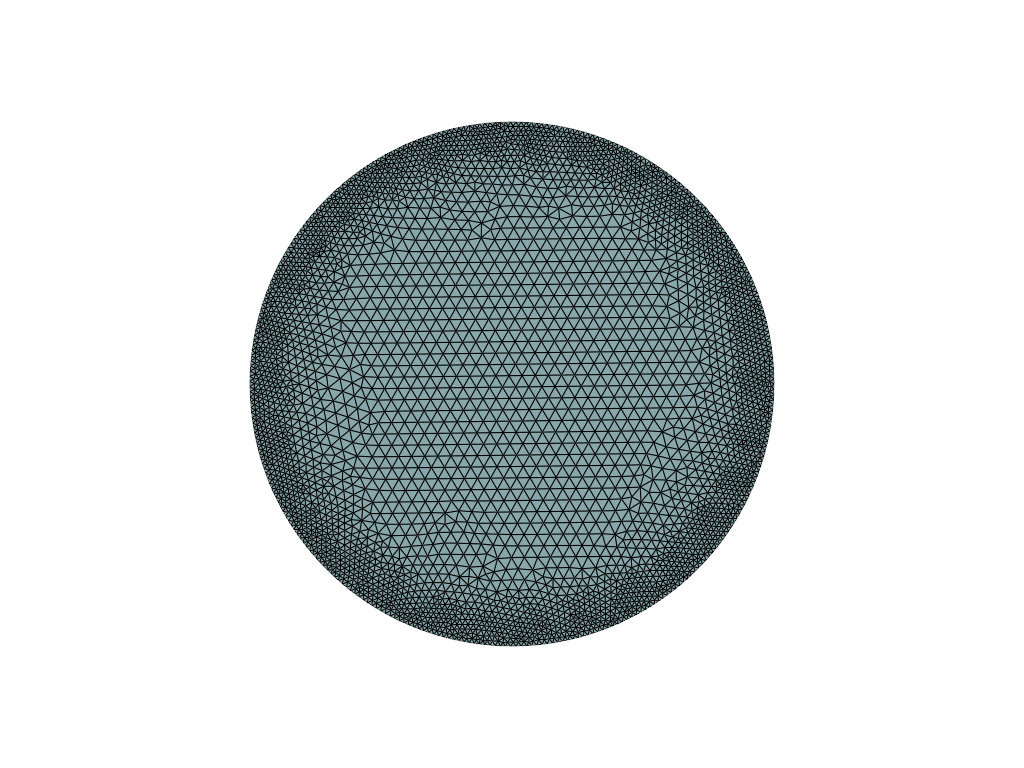

In [8]:
# plotter object settings
# option "static" for static plots. Interactive options were not working properly in colab
#start graphic server
pyvista.start_xvfb()

#convert dolfin mesh to vtk (plotting lib) manageable object
topology_direct, cell_types_direct, x_direct = dolfinx.plot.vtk_mesh(domain_direct)

#set value (plotting zero function in domain)
num_cells_local = domain_direct.topology.index_map(domain_direct.topology.dim).size_local #get vertex array size
marker = np.zeros(num_cells_local, dtype=np.int32) #zero-full array, represents value in each vertex

# Ploting mesh
p = pyvista.Plotter(notebook=True)
grid = pyvista.UnstructuredGrid(topology_direct, cell_types_direct, x_direct)
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

## Setting Inverse mesh

In [9]:
# if running again, you must remove the comment in the following
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 20
points = [gmsh.model.occ.addPoint(np.cos(i*np.pi/(n/2)),np.sin(i*np.pi/(n/2)),0) for i in range(n)]

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2)

# control mesh refinement
# see gmsh tutorial for further instructions
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "PointsList", points)

#sets a threshold field
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)
gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.03)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.2)
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.1)
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.3)

gmsh.model.mesh.field.add("Min", 3)
gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])

gmsh.model.mesh.field.setAsBackgroundMesh(3)

gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)

gmsh.model.mesh.generate(gdim)

#convert gmsh created mesh to dolfin/fenics mesh objects
domain_inverse, cell_markers_inverse, facet_markers_inverse = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

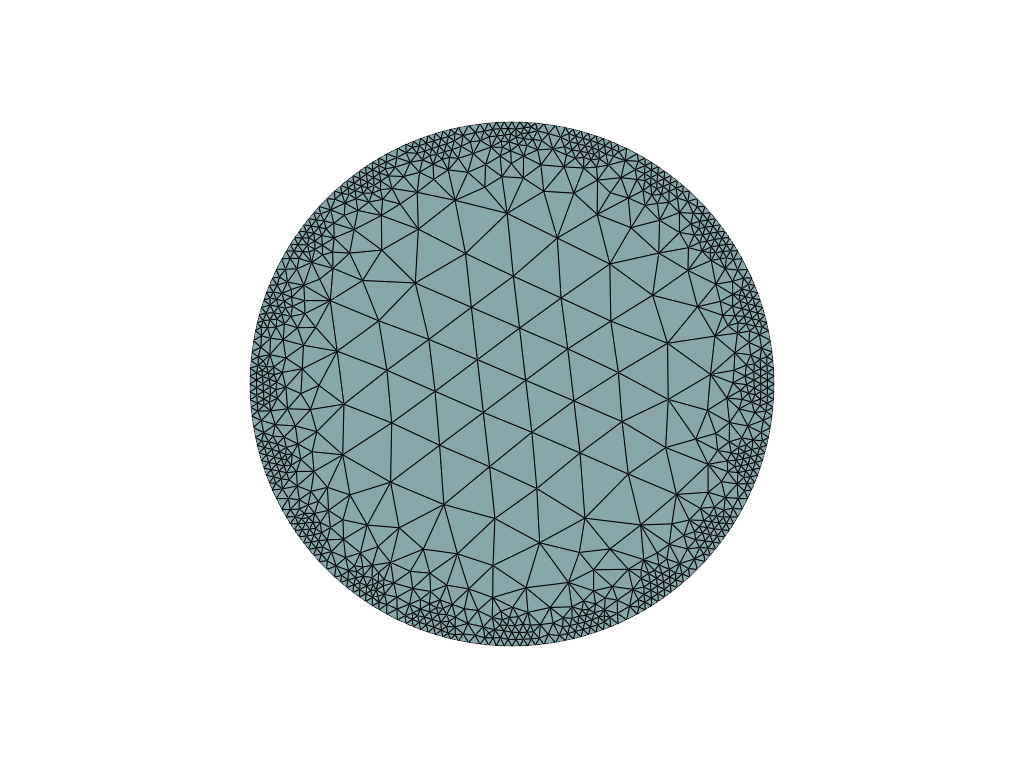

In [10]:
# plotter object settings
# option "static" for static plots. Interactive options were not working properly in colab
#start graphic server
pyvista.start_xvfb()

#convert dolfin mesh to vtk (plotting lib) manageable object
topology_inverse, cell_types_inverse, x_inverse = dolfinx.plot.vtk_mesh(domain_inverse)

#set value (plotting zero function in domain)
num_cells_local = domain_inverse.topology.index_map(domain_inverse.topology.dim).size_local #get vertex array size
marker = np.zeros(num_cells_local, dtype=np.int32) #zero-full array, represents value in each vertex

# Ploting mesh
p = pyvista.Plotter(notebook=True)
grid = pyvista.UnstructuredGrid(topology_inverse, cell_types_inverse, x_inverse)
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

## Setting Function Spaces

In [11]:
V0_dir = dolfinx.fem.FunctionSpace(domain_direct, ("DG",0))
V_dir = dolfinx.fem.FunctionSpace(domain_direct, ("CG",1))

V0_inv = dolfinx.fem.FunctionSpace(domain_inverse, ("DG",0))
V_inv = dolfinx.fem.FunctionSpace(domain_inverse, ("CG",1))

## Defining $\gamma$

In [12]:
def locate_circle_1(x):
  return (x[0]-0.35)**2 + (x[1]-0.35)**2<=0.3**2

def locate_circle_2(x):
  return (x[0]+0.2)**2 + (x[1]+0.2)**2<=0.4**2

gamma_cells_1 = dolfinx.mesh.locate_entities(domain_direct,dim=2, marker=locate_circle_1)
gamma_cells_2 = dolfinx.mesh.locate_entities(domain_direct,dim=2, marker=locate_circle_2)
gamma = dolfinx.fem.Function(V0_dir,dtype=np.complex128)
gamma.x.array[:] = (1+1j)*np.ones_like(gamma.x.array)
gamma.x.array[gamma_cells_1] = (1+4j)*np.ones_like(gamma_cells_1)
gamma.x.array[gamma_cells_2] = (3+1j)*np.ones_like(gamma_cells_2)

### Plot $\gamma$

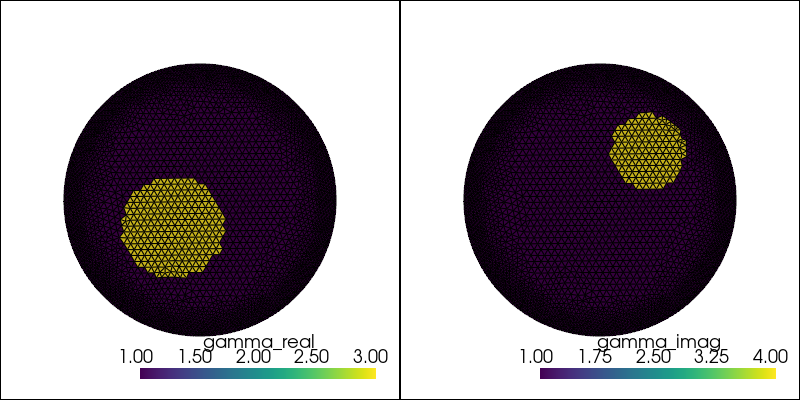

In [13]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_direct,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_dir)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma.x.array.real
grid.cell_data["gamma_imag"] = gamma.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


## Solving direct problem

In [14]:
x = ufl.SpatialCoordinate(domain_direct)
# Defining current array
I_all = []
L = 8 ## number of currents
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all.append(4*(-x[0]*np.sin(theta) + x[1]*np.cos(theta))**2 - 4*(x[0]*np.cos(theta)+x[1]*np.sin(theta))**2)


In [15]:
U_list = solveDirectOperator(gamma,I_all,V_dir)

In [16]:
U_array_list = [u.x.array for u in U_list]
U_array = np.concatenate(U_array_list,axis=None)

In [17]:
U_bdr_array_list = [get_boundary_data(u) for u in U_list]
U_bdr_array = np.concatenate(U_bdr_array_list,axis=None)

### Interpolating from finer to rough mesh


Some aditional steps are needed. About interpolating between meshes: https://fenicsproject.discourse.group/t/runtime-error-when-interpolating-between-non-matching-meshes-with-dolfinx-update/12286

In [18]:
gamma_inv = dolfinx.fem.Function(V0_inv)
gamma_inv.interpolate(gamma,nmm_interpolation_data=dolfinx.fem.create_nonmatching_meshes_interpolation_data(
    gamma_inv.function_space.mesh._cpp_object,
    gamma_inv.function_space.element,
    gamma.function_space.mesh._cpp_object))

In [19]:
U_list_inv = []
for u in U_list:
  u_inv = dolfinx.fem.Function(V_inv)
  u_inv.interpolate(u,nmm_interpolation_data=dolfinx.fem.create_nonmatching_meshes_interpolation_data(
        u_inv.function_space.mesh._cpp_object,
        u_inv.function_space.element,
        u.function_space.mesh._cpp_object))
  U_list_inv.append(u_inv)

In [20]:
U_inv_array_list = [u.x.array for u in U_list_inv]
U_inv_array = np.concatenate(U_inv_array_list,axis=None)

In [21]:
U_inv_bdr_array_list = [get_boundary_data(u) for u in U_list_inv]
U_inv_bdr_array = np.concatenate(U_inv_bdr_array_list,axis=None)

In [22]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_direct,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
i=0
for u_dir,u_inv in zip(U_list,U_list_inv):
  grid.point_data[f"u{i}_dir_real"] = u_inv.x.array.real
  grid.point_data[f"u{i}_dir_imag"] = u_inv.x.array.imag
  # grid.point_data[f"u{i}_inv_real"] = u_inv.x.array.real
  # grid.point_data[f"u{i}_inv_imag"] = u_inv.x.array.imag

  i+=1
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")


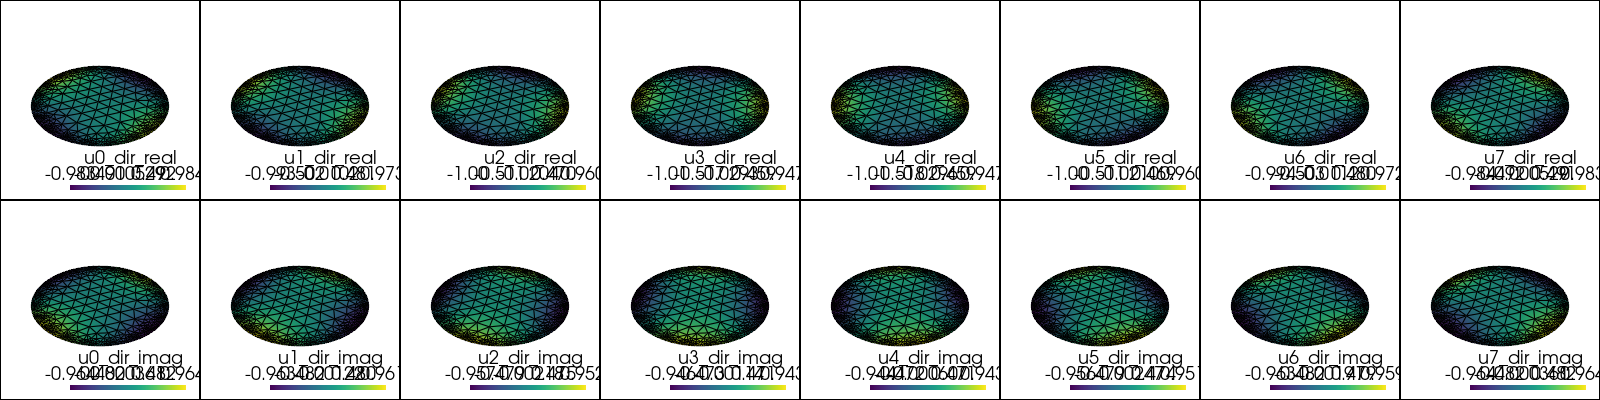

In [23]:
p = pyvista.Plotter(shape=(2,L),notebook=True,window_size=(1600,400))

# p.view_xy()
for i in range(len(U_list)):
  p.subplot(0,i)
  p.add_mesh(grid,show_edges=True,copy_mesh=True,scalars=f"u{i}_dir_real")
  p.subplot(1,i)
  p.add_mesh(grid,show_edges=True,copy_mesh=True,scalars=f"u{i}_dir_imag")
  # p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")

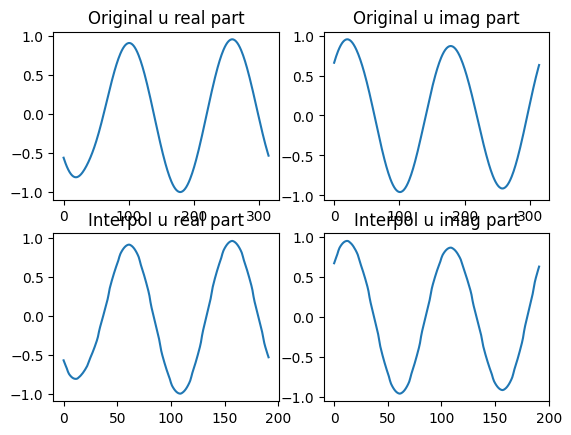

In [24]:
# comparing border data
u0_interp_bdr = get_boundary_data(U_list_inv[2])
u0_bdr = get_boundary_data(U_list[2])

fig, ax = plt.subplots(2,2)
ax[1][0].plot(u0_interp_bdr.real)
ax[1][0].set_title("Interpol u real part")
ax[1][1].plot(u0_interp_bdr.imag)
ax[1][1].set_title("Interpol u imag part")
ax[0][0].plot(u0_bdr.real)
ax[0][0].set_title("Original u real part")
ax[0][1].plot(u0_bdr.imag)
ax[0][1].set_title("Original u imag part")
plt.show()

## Levenberg - Marquardt
Using here Levenberg-Marquardt method

$$
  s_{n} = \arg\min \frac 1 2 \| F'(x_n)s-b_n^\delta\|^2 + \frac \alpha 2 \|s\|^2  \\
  x_{n+1} = x_n + s_n
$$
Where $s_n$ may be obtained solving
$$
(F'(x_n)^*F'(x_n) + \alpha I)s_n = F'(x_n)^*(y^\delta - F(x_n))
$$

In [ ]:
inverse_bdr_index =get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)

In [ ]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution

x_inv = ufl.SpatialCoordinate(domain_inverse)
# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [ ]:
alpha = 1e-4
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:

sn = np.zeros_like(gamma_sol.x.array)
for n in range(20):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

  U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
  U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

  res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
  print("Residual:", res)
  res_array.append(res)
  #calc Jacobian
  print("Starting Jacobian calc")
  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)

  #selecting only parts respective to bdr
  J_idx = Jacobian[jacobian_bdr_index]

  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]
  sn = np.linalg.solve(J_idx.conj().T @ J_idx + alpha/2*np.eye(n), J_idx.conj().T @ (U_inv_bdr_array - U_gamma_bdr_array))
  gamma_sol.x.array[:] += sn

  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))

  alpha *= 0.7


Starting iteration 0
Residual: 4.608690897865418
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  12.623973369598389 s
Starting calc for current 1
Solved directional derivatives in  12.473232507705688 s
Starting calc for current 2
Solved directional derivatives in  12.582700967788696 s
Starting calc for current 3
Solved directional derivatives in  12.214568138122559 s
Starting calc for current 4
Solved directional derivatives in  12.283982753753662 s
Starting calc for current 5
Solved directional derivatives in  12.521630048751831 s
Starting calc for current 6
Solved directional derivatives in  12.302653789520264 s
Starting calc for current 7
Solved directional derivatives in  12.283400535583496 s
Starting calc for current 8
Solved directional derivatives in  12.357311487197876 s
Starting calc for current 9
Solved directional derivatives in  12.43065881729126 s
Starting calc for current 10
Solved directional derivatives in  12.406981945037842 s
Star

KeyboardInterrupt: 

In [ ]:
norm_gamma = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(gamma_inv,gamma_inv)*ufl.dx))


In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
print("Residual:", res)
res_array.append(res)

Residual: 0.0008465745615016045


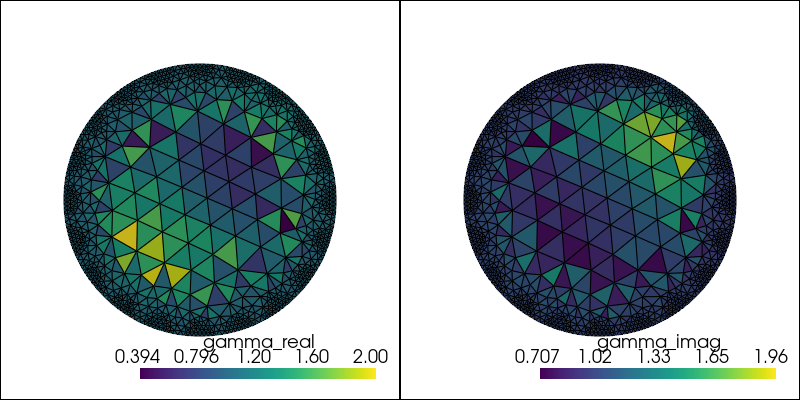

In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


In [ ]:
print("Real part error",np.linalg.norm(gamma_sol.x.array.real-gamma_inv.x.array.real))
print("Imag part error",np.linalg.norm(gamma_sol.x.array.imag-gamma_inv.x.array.imag))

Real part error 8.818897307101373
Imag part error 10.21610937860757


In [ ]:
err_array[-1]/np.linalg.norm(gamma_inv.x.array)

0.2183314713732558

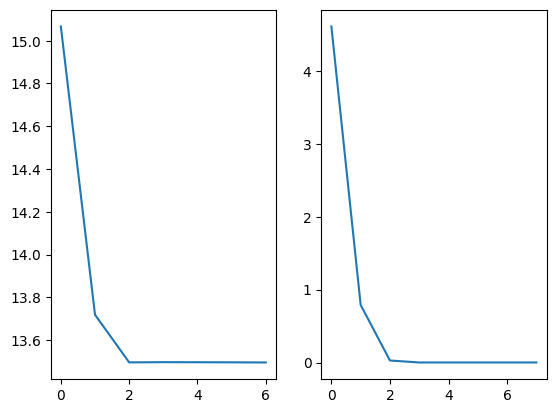

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array)
ax[1].plot(res_array)
plt.show()

### Weighted Jacobian



#### Steps

Getting triangle sizes by method sugested in https://fenicsproject.discourse.group/t/computing-mesh-element-size/12202

In [ ]:
# Obs: needs to compute only once
v = ufl.TrialFunction(V0_inv)
# c = dolfinx.fem.Constant(domain_inverse, PETSc.ScalarType(1))
cell_area_form = dolfinx.fem.form(v * ufl.dx)
cell_area = dolfinx.fem.assemble_vector(cell_area_form)
area_array = cell_area.array.real

In [ ]:
area_func = dolfinx.fem.Function(V0_dir)
area_array = np.zeros_like(area_func.x.array)
for i in range(len(area_func.x.array)):
  area_func.x.array[i] = 1
  dolfinx.fem.form(PETSc.Sca * ufl.dx)
  area_func.x.array[i] = 0

In [ ]:
jacobian_column_norms = np.apply_along_axis(np.linalg.norm,0,Jacobian)
gamma_norms = abs(gamma_sol.x.array) #gamma absolute values array
diag_array = jacobian_column_norms* (1/gamma_norms)*(1/area_vector) #diagonal array
diag_matrix = np.diag(diag_array)
weighted_jac = diag_matrix @ Jacobian.conj().T

Creating matrix:

In [ ]:
Creating matriix

#### Testing on inverse problem

In [ ]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution
inverse_bdr_index =get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)
x_inv = ufl.SpatialCoordinate(domain_inverse)

# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,8)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [ ]:
alpha = 0.000001
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:

sn = np.zeros_like(gamma_sol.x.array)
for n in range(5):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

  U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
  U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

  print("Residual:", np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array))
  res_array.append(np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array))

  #calc Jacobian
  print("Starting Jacobian calc")
  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)


  #Adding weight to Jacobian
  jacobian_column_norms = np.apply_along_axis(np.linalg.norm,0,Jacobian)
  gamma_norms = abs(gamma_sol.x.array)
  diag_array = jacobian_column_norms * (1/area_array) * (1/gamma_norms) #diagonal array
  diag_matrix = np.diag(diag_array)

  #selecting only parts respective to bdr
  J_idx = Jacobian[jacobian_bdr_index]
  weighted_J_idx = diag_matrix @ J_idx.conj().T


  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]
  sn = np.linalg.solve(weighted_J_idx @ J_idx + alpha/2*np.eye(n), weighted_J_idx @ (U_inv_bdr_array - U_gamma_bdr_array))
  gamma_sol.x.array[:] += sn

  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))

  alpha *= 0.6


Starting iteration 0
Residual: 3.5468242198179043
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  12.08071494102478 s
Starting calc for current 1
Solved directional derivatives in  12.432615756988525 s
Starting calc for current 2
Solved directional derivatives in  12.196906328201294 s
Starting calc for current 3
Solved directional derivatives in  11.84568738937378 s
Starting calc for current 4
Solved directional derivatives in  11.346340417861938 s
Starting calc for current 5
Solved directional derivatives in  11.431926012039185 s
Starting calc for current 6
Solved directional derivatives in  12.067186117172241 s
Starting calc for current 7
Solved directional derivatives in  12.074810028076172 s
Solving system
System solved, updated gamma_sol 

Error: 12.271628723257884
Starting iteration 1
Residual: 0.5495778691272959
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  11.56617021560669 s
Starting calc for current

In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

print("Residual:", np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array))


Residual: 0.16493447709638265


In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(notebook=True,window_size=(800,400))
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")


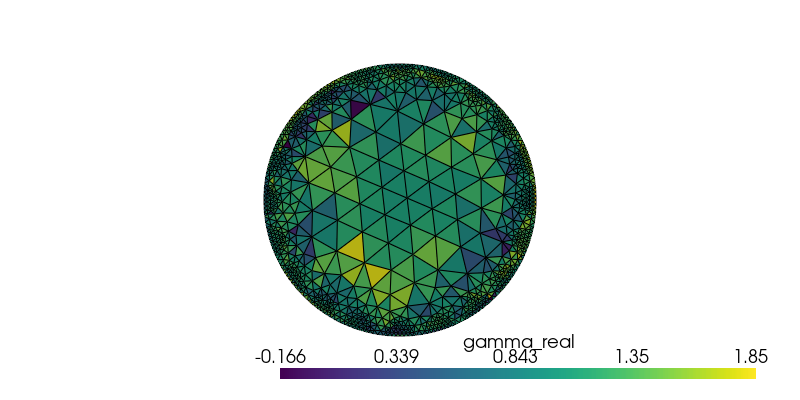

In [ ]:
grid.set_active_scalars("gamma_real")
p.add_mesh(grid,show_edges=True)
p.view_xy()
# p.subplot(0,1)
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")

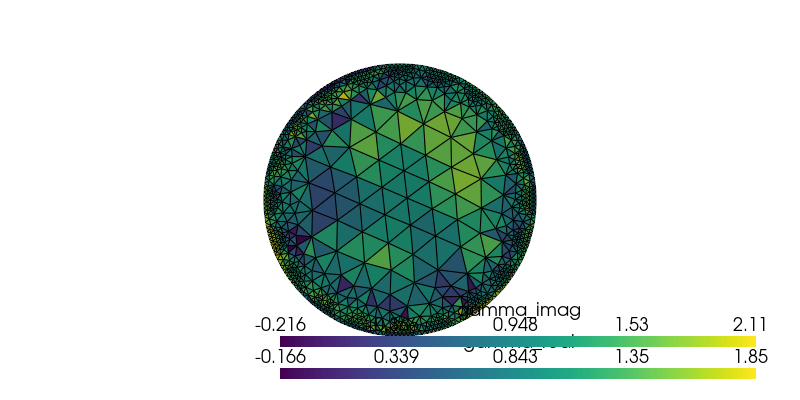

In [ ]:
grid.set_active_scalars("gamma_imag")
p.add_mesh(grid,show_edges=True)
p.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")

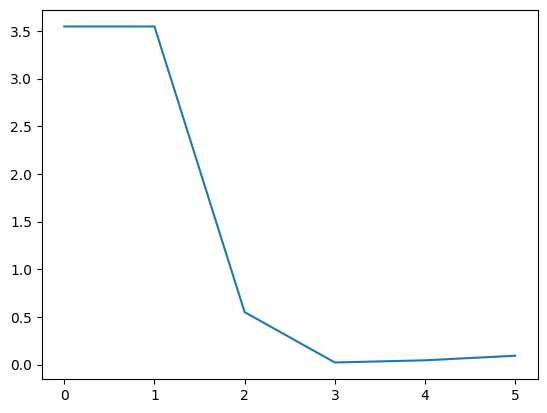

In [ ]:
plt.plot(res_array)

## Landweber

$$
x_{n+1} = x_n - \alpha F'(x_n)^*(F(x_n) - y^\delta)
$$

In [ ]:
y =

In [ ]:
inverse_bdr_index =get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)

In [ ]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution

x_inv = ufl.SpatialCoordinate(domain_inverse)
# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [ ]:
alpha = 1
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:

sn = np.zeros_like(gamma_sol.x.array)
for n in range(5):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

  U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
  U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

  res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
  print("Residual:", res)
  res_array.append(res)
  #calc Jacobian
  print("Starting Jacobian calc")
  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)

  #selecting only parts respective to bdr
  J_idx = Jacobian[jacobian_bdr_index]

  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]
  sn = -alpha * J_idx.T.conj() @ (U_gamma_bdr_array - U_inv_bdr_array)
  gamma_sol.x.array[:] += sn

  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))

  alpha *= 0.7


Starting iteration 0
Residual: 3.7653174091499837
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  16.07007598876953 s
Starting calc for current 1
Solved directional derivatives in  15.12576174736023 s
Starting calc for current 2
Solved directional derivatives in  14.539109230041504 s
Starting calc for current 3
Solved directional derivatives in  14.51737642288208 s
Starting calc for current 4
Solved directional derivatives in  14.455049514770508 s
Starting calc for current 5
Solved directional derivatives in  15.827325582504272 s
Starting calc for current 6
Solved directional derivatives in  15.036370992660522 s
Starting calc for current 7
Solved directional derivatives in  15.253662586212158 s
Solving system
System solved, updated gamma_sol 

Error: 13.602106236081537
Starting iteration 1
Residual: 1.2099360115004527
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  14.93799877166748 s
Starting calc for current 

KeyboardInterrupt: 

In [ ]:
norm_gamma = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(gamma_inv,gamma_inv)*ufl.dx))


In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
print("Residual:", res)
res_array.append(res)

Residual: 36.19908447419096


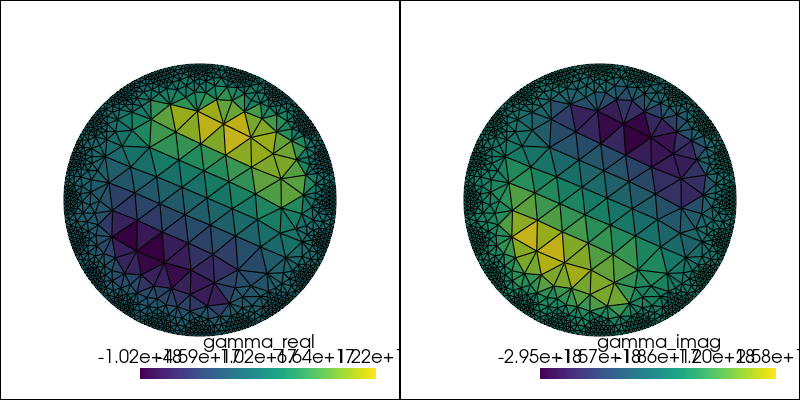

In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


In [ ]:
print("Real part error",np.linalg.norm(gamma_sol.x.array.real-gamma_inv.x.array.real))
print("Imag part error",np.linalg.norm(gamma_sol.x.array.imag-gamma_inv.x.array.imag))

Real part error 7.440953141738903e+18
Imag part error 1.80106607131806e+19


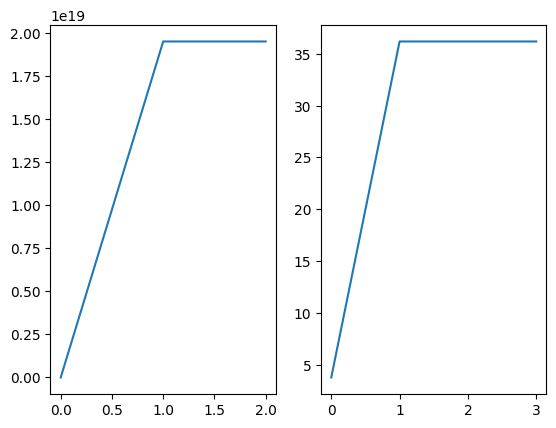

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array)
ax[1].plot(res_array)
plt.show()

## REGINN - Gradiente

In [ ]:
inverse_bdr_index =get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)

In [ ]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution

x_inv = ufl.SpatialCoordinate(domain_inverse)
# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [ ]:
alpha = 10
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:
for n in range(15):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

  U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
  U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

  residual = U_gamma_bdr_array-U_inv_bdr_array
  residual_norm = np.linalg.norm(residual)
  print("Residual:", residual_norm)
  res_array.append(residual_norm)
  #calc Jacobian
  print("Starting Jacobian calc")
  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)

  #selecting only parts respective to bdr
  J_idx = Jacobian[jacobian_bdr_index]

  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]

  lmbda = 1
  sn = np.zeros_like(gamma_sol.x.array)
  for i in range(50):
    inter_res = J_idx@sn + residual
    if np.linalg.norm(inter_res) < residual_norm:
      break
    sn -= lmbda*J_idx.T.conj()@inter_res

  gamma_sol.x.array[:] += sn

  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


Starting iteration 0
Residual: 3.7653174091499837
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  15.831898927688599 s
Starting calc for current 1
Solved directional derivatives in  15.641705513000488 s
Starting calc for current 2
Solved directional derivatives in  16.029454469680786 s
Starting calc for current 3
Solved directional derivatives in  15.711654901504517 s
Starting calc for current 4
Solved directional derivatives in  15.654272079467773 s
Starting calc for current 5
Solved directional derivatives in  15.333243131637573 s
Starting calc for current 6
Solved directional derivatives in  15.607587337493896 s
Starting calc for current 7
Solved directional derivatives in  16.883339166641235 s
Solving system
System solved, updated gamma_sol 

Error: 1.9487218451663675e+19
Starting iteration 1
Residual: 36.19908447419096
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  13.39358377456665 s
Starting calc for cu

KeyboardInterrupt: 

In [ ]:
norm_gamma = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(gamma_inv,gamma_inv)*ufl.dx))


In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
print("Residual:", res)
res_array.append(res)

In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


In [ ]:
print("Real part error",np.linalg.norm(gamma_sol.x.array.real-gamma_inv.x.array.real))
print("Imag part error",np.linalg.norm(gamma_sol.x.array.imag-gamma_inv.x.array.imag))

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array)
ax[1].plot(res_array)
plt.show()

## REGINN - Tikhonov

In [ ]:
inverse_bdr_index =get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)

In [ ]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution

x_inv = ufl.SpatialCoordinate(domain_inverse)
# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [ ]:
alpha = 1e-3
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:
for n in range(15):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

  U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
  U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

  residual = U_gamma_bdr_array-U_inv_bdr_array
  residual_norm = np.linalg.norm(residual)
  print("Residual:", residual_norm)
  res_array.append(residual_norm)
  #calc Jacobian
  print("Starting Jacobian calc")
  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)

  #selecting only parts respective to bdr
  J_idx = Jacobian[jacobian_bdr_index]

  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]

  sn = np.zeros_like(gamma_sol.x.array)
  for i in range(5):
    inter_res = J_idx@sn + residual
    if np.linalg.norm(inter_res) < residual_norm:
      break
    sn = np.linalg.solve(J_idx.T.conj() @ J_idx + alpha*np.eye(n), J_idx.T.conj() @ (-residual) + alpha * sn)

  gamma_sol.x.array[:] += sn

  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


Starting iteration 0
Residual: 4.608690897865418
Starting Jacobian calc
Starting calc for current 0
Solved directional derivatives in  12.683992624282837 s
Starting calc for current 1
Solved directional derivatives in  12.331642866134644 s
Starting calc for current 2
Solved directional derivatives in  12.456393241882324 s
Starting calc for current 3
Solved directional derivatives in  12.76569128036499 s
Starting calc for current 4
Solved directional derivatives in  12.315261125564575 s
Starting calc for current 5
Solved directional derivatives in  12.30700945854187 s
Starting calc for current 6
Solved directional derivatives in  12.235723733901978 s
Starting calc for current 7
Solved directional derivatives in  12.292672634124756 s
Starting calc for current 8
Solved directional derivatives in  12.140457391738892 s
Starting calc for current 9
Solved directional derivatives in  12.213831424713135 s
Starting calc for current 10
Solved directional derivatives in  12.257548093795776 s
Start

KeyboardInterrupt: 

In [ ]:
norm_gamma = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(gamma_inv,gamma_inv)*ufl.dx))


In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
print("Residual:", res)
res_array.append(res)

Residual: 0.0008456109335958476


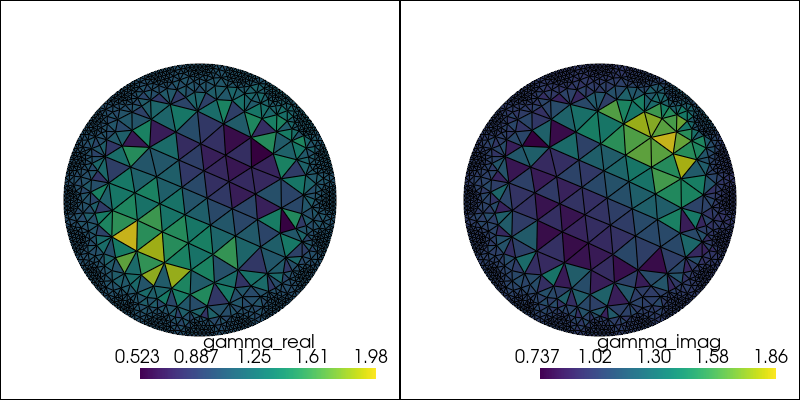

In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


In [ ]:
print("Real part error",np.linalg.norm(gamma_sol.x.array.real-gamma_inv.x.array.real))
print("Imag part error",np.linalg.norm(gamma_sol.x.array.imag-gamma_inv.x.array.imag))

Real part error 8.632684390361915
Imag part error 10.112153473272201


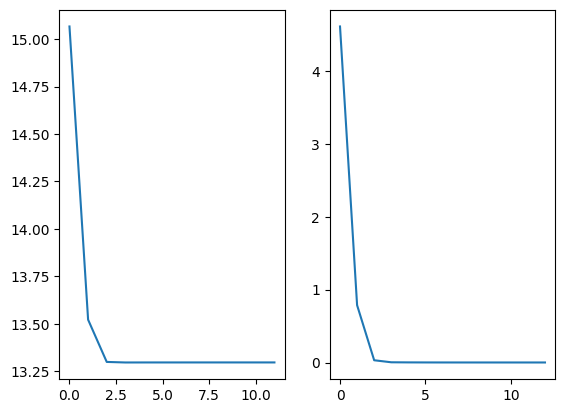

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array)
ax[1].plot(res_array)
plt.show()

Relative Error


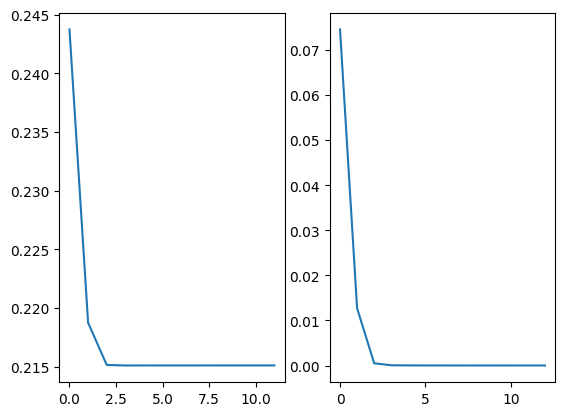

In [ ]:
print("Relative Error")
gamma_norm = np.linalg.norm(gamma_inv.x.array)
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array/gamma_norm)
ax[1].plot(res_array/gamma_norm)
plt.show()

## Adjoint in Inverse problems

Tests with the adjoint computed by variational form used in the inverse problem

Here using naive inverse problem, i.e., with whole body info, not only boundary.

In [25]:
y = U_inv_array

In [26]:
U_array

array([ 0.86040059-0.95607529j,  0.83490395-0.93081111j,
        0.86409313-0.96019247j, ..., -0.79734838+0.71516021j,
       -0.98303342+0.88431069j, -0.9840144 +0.885528j  ])

In [27]:
inverse_bdr_index = get_boundary_index(V_inv)
N_inv = V_inv.dofmap.index_map.size_global
jacobian_bdr_index = np.concatenate([inverse_bdr_index + i*N_inv for i in range(len(I_all))],axis=None)

In [28]:
# setting I_all in V_inverse domain
# for now, splitting lists because the SpatialCoordinate object is set for each domain
# TODO: verify another solution

x_inv = ufl.SpatialCoordinate(domain_inverse)
# Defining current array
I_all_inv = []
theta_array = np.linspace(0,np.pi/2,L)
for theta in theta_array:
  I_all_inv.append(4*(-x_inv[0]*np.sin(theta) + x_inv[1]*np.cos(theta))**2 - 4*(x_inv[0]*np.cos(theta)+x_inv[1]*np.sin(theta))**2)

In [29]:
alpha = 0.1
#creating first guess
gamma_sol = dolfinx.fem.Function(V0_inv,dtype=np.complex128)
gamma_sol.x.array[:] =(1+1j)*np.ones_like(gamma_sol.x.array)

err_array = []
res_array = []
err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))


In [ ]:
sn = np.zeros_like(gamma_sol.x.array)
for n in range(30):
  #get bdr u data
  print("Starting iteration",n)
  U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)
  U_gamma_array_list = [U.x.array for U in U_gamma_list]
  U_gamma_array = np.concatenate(U_gamma_array_list,axis=None)
  res = np.linalg.norm(U_gamma_array-y)
  print("Residual:", res)
  res_array.append(res)
  #calc Jacobian

  # print("Solving system")
  # Residual_list = np.split(U_gamma_array-y, L)
  # adj = calcAdjoint(gamma_sol,U_gamma_list,Residual_list,V_inv)
  # #solve
  # n = gamma_sol.x.array.shape[0]
  # sn = - alpha * adj

  Jacobian = calcJacobianMatrix(gamma_sol,U_gamma_list,I_all_inv)

  #selecting only parts respective to bdr

  print("Solving system")
  #solve
  n = gamma_sol.x.array.shape[0]
  sn = -alpha * Jacobian.T.conj() @ (U_gamma_array - y)

  gamma_sol.x.array[:] += sn



  err_array.append(np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))
  print("System solved, updated gamma_sol","\n")
  print("Error:", np.linalg.norm(gamma_sol.x.array - gamma_inv.x.array))

Starting iteration 0
Residual: 8.541404329799208
Starting calc for current 0
Solved directional derivatives in  14.648010730743408 s
Starting calc for current 1
Solved directional derivatives in  13.640372037887573 s
Starting calc for current 2
Solved directional derivatives in  13.989644289016724 s
Starting calc for current 3
Solved directional derivatives in  14.2935209274292 s
Starting calc for current 4
Solved directional derivatives in  13.407028436660767 s
Starting calc for current 5
Solved directional derivatives in  13.54255986213684 s
Starting calc for current 6
Solved directional derivatives in  13.640927791595459 s
Starting calc for current 7
Solved directional derivatives in  14.217854738235474 s
Solving system
System solved, updated gamma_sol 

Error: 14.157385705636107
Starting iteration 1
Residual: 4.047359591501671
Starting calc for current 0
Solved directional derivatives in  15.300028085708618 s
Starting calc for current 1
Solved directional derivatives in  15.9018995

In [ ]:
norm_gamma = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(gamma_inv,gamma_inv)*ufl.dx))


In [ ]:
U_gamma_list = solveDirectOperator(gamma_sol,I_all_inv,V_inv)

U_gamma_bdr_list = [get_boundary_data(u) for u in U_gamma_list]
U_gamma_bdr_array = np.concatenate(U_gamma_bdr_list,axis=None)

res = np.linalg.norm(U_gamma_bdr_array-U_inv_bdr_array)
print("Residual:", res)
res_array.append(res)

Residual: 0.8648820115592862


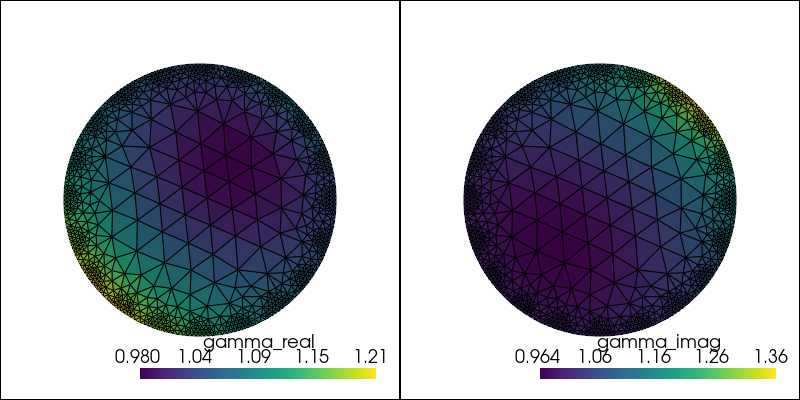

In [ ]:
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain_inverse,dim=2))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V_inv)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.cell_data["gamma_real"] = gamma_sol.x.array.real
grid.cell_data["gamma_imag"] = gamma_sol.x.array.imag
p = pyvista.Plotter(shape=(1,2),notebook=True,window_size=(800,400))#,shape=(1,2),)
# p.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p.subplot(0,0)
p.add_mesh(grid,scalars="gamma_real",show_edges=True,copy_mesh=True)
p.view_xy()
p.subplot(0,1)
p.add_mesh(grid,scalars="gamma_imag",show_edges=True,copy_mesh=True)
p.view_xy()
p.set_background("white")
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="static")


In [ ]:
print("Real part error",np.linalg.norm(gamma_sol.x.array.real-gamma_inv.x.array.real))
print("Imag part error",np.linalg.norm(gamma_sol.x.array.imag-gamma_inv.x.array.imag))

Real part error 10.241719498359435
Imag part error 12.411383022194627


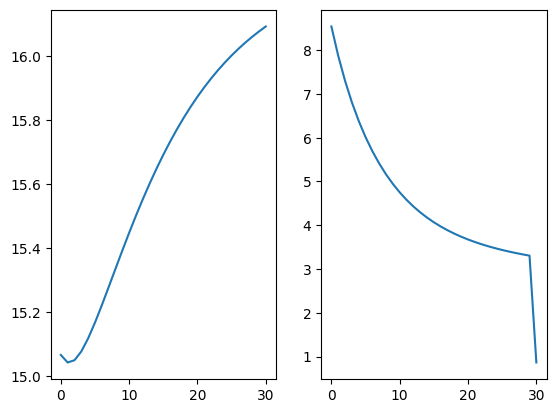

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(err_array)
ax[1].plot(res_array)
plt.show()

# Extra tests

## Plotting 3d view for solution

Here there is also an example of defining alternative functions. Second block contains de definition of function
$$
u = e^{-\frac{(x^2 + y^2)}{2}}
$$


In [ ]:
# if running again, you must remove the comment in the following
from dolfinx.io import gmshio
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 20

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2)


gmsh.model.mesh.generate(gdim)


gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

#convert dolfin mesh to vtk (plotting lib) manageable object
topology, cell_types, x = dolfinx.plot.vtk_mesh(domain)


In [ ]:
ufl.cos

<function ufl.operators.cos(f)>

In [ ]:
V = dolfinx.fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain
V2 = dolfinx.fem.FunctionSpace(domain, ("CG", 2))

#defining expression
utest = dolfinx.fem.Function(V)
x = ufl.SpatialCoordinate(domain)
expr = ufl.exp(-(x[0]**2+x[1]**2)/0.2)
expression = dolfinx.fem.Expression(expr, V.element.interpolation_points())
utest.interpolate(expression)

pyvista.global_theme.font.color = "black"
pyvista.global_theme.color = "white"
pyvista.start_xvfb()

p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = utest.x.array.real
grid.point_data["u_imag"] = utest.x.array.imag

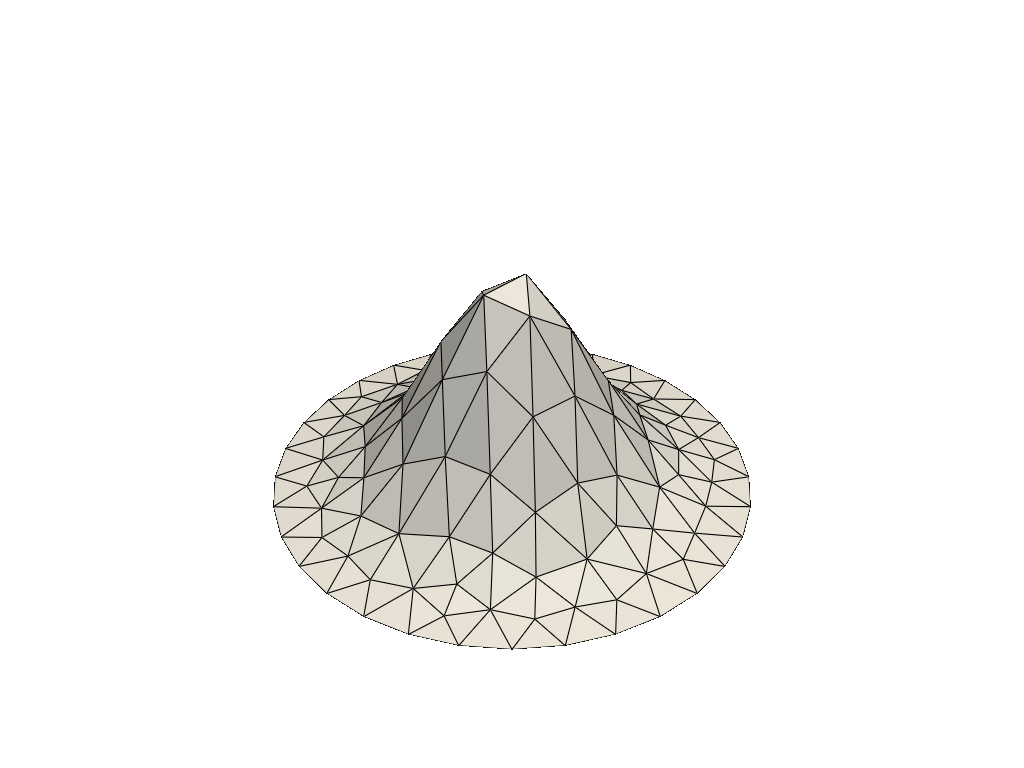

In [ ]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter(notebook=True)
# p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid.warp_by_scalar(),color="w",show_edges=True)
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

## Testing Discontinuous functions

The following tests are for defining and plotting piecewise defined functions. In our case, becames relevant because $\gamma$ admitivities are expressed as piecewise constant in discretization.

Following tutorial brings an example in the subject: https://jsdokken.com/dolfinx-tutorial/chapter3/subdomains.html

In [ ]:
# if running again, you must remove the comment in the following
from dolfinx.io import gmshio
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 20

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2)


gmsh.model.mesh.generate(gdim)


gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

#convert dolfin mesh to vtk (plotting lib) manageable object
topology, cell_types, x = dolfinx.plot.vtk_mesh(domain)


In [ ]:
V0 = dolfinx.fem.FunctionSpace(domain, ("DG", 0)) #DG, 0 stands for "Discontinuous Garlekin", 0 degree

In [ ]:
gamma = dolfinx.fem.Function(V0)
x = ufl.SpatialCoordinate(domain)
expr = x[0]**2 + x[1]**2
expression = dolfinx.fem.Expression(expr, V0.element.interpolation_points())
gamma.interpolate(expression)

In [ ]:

pyvista.global_theme.font.color = "black"
pyvista.global_theme.color = "white"
pyvista.start_xvfb()

pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.cell_data["u_real"] = gamma.x.array.real
# grid.point_data["u_imag"] = gamma.x.array.imag

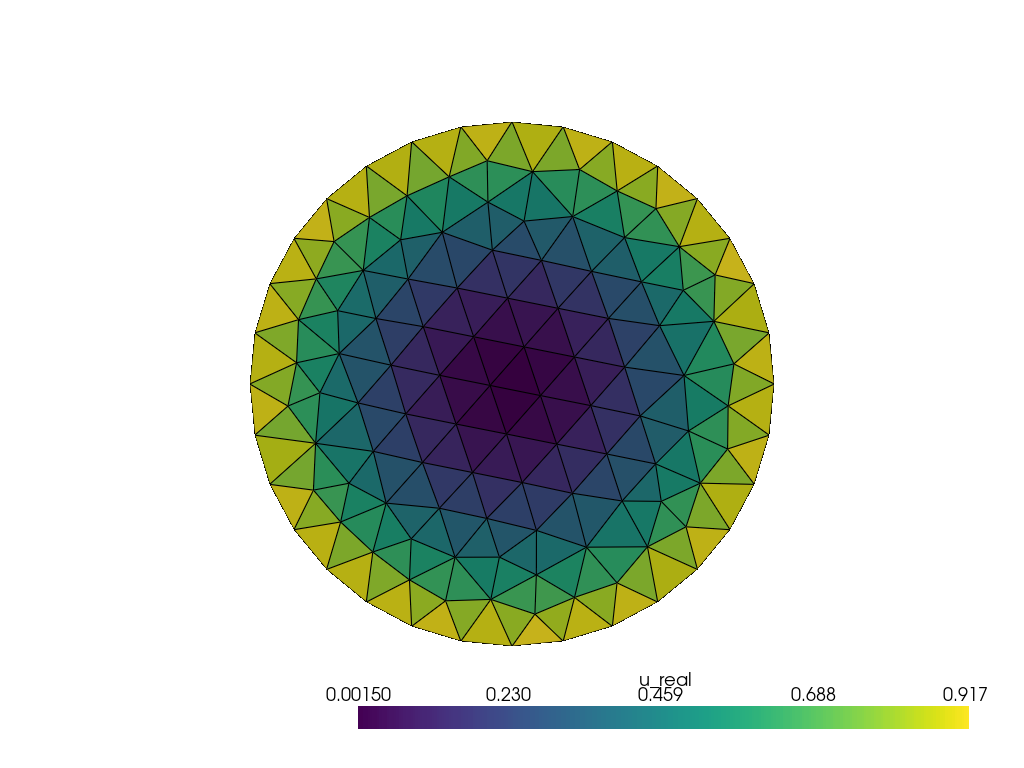

In [ ]:
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter(notebook=True)
# p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")

## Getting cell coordinates

In [ ]:
# if running again, you must remove the comment in the following
from dolfinx.io import gmshio
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
n = 20

gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)
# gmsh.model.addPhysicalGroup(0, points, 2) #electrodes

# control max length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2)


gmsh.model.mesh.generate(gdim)


gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

#convert dolfin mesh to vtk (plotting lib) manageable object
topology, cell_types, x = dolfinx.plot.vtk_mesh(domain)


In [ ]:
V0 = dolfinx.fem.FunctionSpace(domain, ("DG", 0)) #DG, 0 stands for "Discontinuous Garlekin", 0 degree

In [ ]:
adjacency_list = domain.topology.connectivity(2,0)
mesh_vertex_index_list = []
for i in range(len(adjacency_list)):
  mesh_vertex_index_list.append(adjacency_list.links(i))

In [ ]:
cells_coordinates_list = []
for cell_vertex_index in mesh_vertex_index_list:
  cells_coordinates_list.append(domain.geometry.x[mesh_vertex_index_list[0]][:,:2])

In [ ]:
mesh_vertex_index_list[0]

array([0, 1, 2], dtype=int32)

In [ ]:
cell0

array([[3.39190141e-15, 1.00000000e+00],
       [7.82716855e-02, 8.09648951e-01],
       [1.95090322e-01, 9.80785280e-01]])

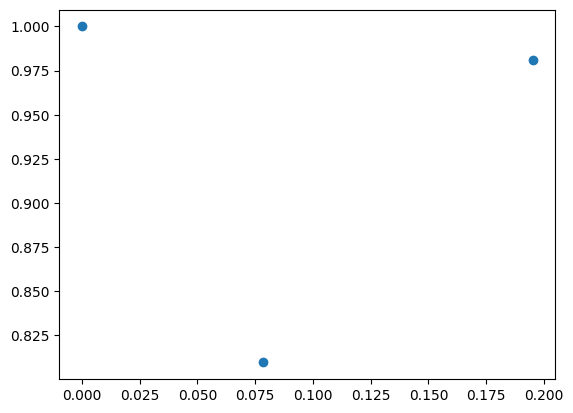

In [ ]:
cell0 = cells_coordinates_list[0]
plt.scatter(cell0[:,0],cell0[:,1])

In [ ]:
dolfinx.cpp.mesh.entities_to_geometry(domain,2,cell_markers.indices,False)

TypeError: ignored

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Computing cell areas


Getting triangle sizes by method sugested in https://fenicsproject.discourse.group/t/computing-mesh-element-size/12202

In [ ]:
area_array_iter

In [ ]:
#

In [ ]:
# Obs: needs to compute only once
v = ufl.TrialFunction(V0_inv)
# c = dolfinx.fem.Constant(domain_inverse, PETSc.ScalarType(1))
cell_area_form = dolfinx.fem.form(v * ufl.dx)
cell_area = dolfinx.fem.assemble_vector(cell_area_form)
area_array = cell_area.array.real

In [ ]:
area_func = dolfinx.fem.Function(V0_inv)
area_array_iter = np.zeros_like(area_func.x.array)
for i in range(len(area_func.x.array)):
  area_func.x.array[i] = 1
  form = dolfinx.fem.form(area_func * ufl.dx)
  area_array_iter[i] = dolfinx.fem.assemble_scalar(form).real
  area_func.x.array[i] = 0

In [ ]:
area_array_iter

array([0.00039041+0.j, 0.00038171+0.j, 0.00037578+0.j, ...,
       0.00038235+0.j, 0.00037506+0.j, 0.00037956+0.j])

In [ ]:
area_array-area_array_iter

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])